In [1]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_lcbench_varying_cost_runs(data, acq):
    runs = api.runs(path="ziv-scully-group/StoppingBayesOptEmpirical", filters={
        "sweep": "e2hd88fe",
        "config.dataset_name": data,
        "config.acquisition_function": acq},
        )
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["config id", "cumulative cost", "current best id", "current best observed", "StablePBGI(1e-3) acq", "StablePBGI(1e-4) acq", "StablePBGI(1e-5) acq", "LogEIC acq", "regret upper bound", "exp min regret gap", "PRB"]
        history = list(run.scan_history(keys = metric_keys, page_size=1_000_000_000))
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [2]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = {
        "LogEIC": "LogEIC",
        "StablePBGI(1e-3)": "PBGI(1e-3)",
        "StablePBGI(1e-4)": "PBGI(1e-4)", 
        "StablePBGI(1e-5)": "PBGI(1e-5)", 
        "LCB": "LCB",
        "TS": "TS"
    }

In [3]:
grouped_runs = {(d, a): load_lcbench_varying_cost_runs(d, a) for d in dataset_names for a in acquisition_functions}

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


In [4]:
from collections import defaultdict
import numpy as np

# Create a single nested defaultdict for all metrics
metrics_per_acq = defaultdict(lambda: defaultdict(dict))

for d in dataset_names:
    for a in acquisition_functions.keys():
        config_and_metrics_per_seed = grouped_runs[(d, a)]

        # Extract metrics along with the seeds for sorting
        seeds_and_metrics = [
            (
                config['seed'],
                m['cumulative cost'],
                m['config id'],
                m['current best id'],
                m['current best observed'],
                m['StablePBGI(1e-3) acq'],
                m['StablePBGI(1e-4) acq'],
                m['StablePBGI(1e-5) acq'],
                m['LogEIC acq'],
                m['exp min regret gap'],
                m['regret upper bound'],
                m['PRB']
            )
            for config, m in config_and_metrics_per_seed
            if len(m['current best observed']) > 0
        ]

        # Sort by seed
        seeds_and_metrics.sort(key=lambda x: x[0])

        # Extract sorted metrics
        metric_keys = [
            "cumulative cost",
            "config id",
            "current best id",
            "current best observed",
            "PBGI(1e-3) acq",
            "PBGI(1e-4) acq",
            "PBGI(1e-5) acq",
            "LogEIC acq",
            "exp min regret gap",
            "regret upper bound",
            "PRB"
        ]

        arrays = [
            np.array([item[i + 1] for item in seeds_and_metrics], dtype=int if "id" in key else float)
            for i, key in enumerate(metric_keys)
        ]

        print(d, a, arrays[1].shape)  # config_id is arrays[1]

        for key, array in zip(metric_keys, arrays):
            metrics_per_acq[d][acquisition_functions[a]][key] = array

Fashion-MNIST LogEIC (50, 201)
Fashion-MNIST StablePBGI(1e-3) (50, 201)
Fashion-MNIST StablePBGI(1e-4) (50, 201)
Fashion-MNIST StablePBGI(1e-5) (50, 201)
Fashion-MNIST LCB (50, 201)
Fashion-MNIST TS (50, 201)
adult LogEIC (50, 201)
adult StablePBGI(1e-3) (50, 201)
adult StablePBGI(1e-4) (50, 201)
adult StablePBGI(1e-5) (50, 201)
adult LCB (50, 201)
adult TS (50, 201)
higgs LogEIC (50, 201)
higgs StablePBGI(1e-3) (50, 201)
higgs StablePBGI(1e-4) (50, 201)
higgs StablePBGI(1e-5) (50, 201)
higgs LCB (50, 201)
higgs TS (50, 201)
volkert LogEIC (50, 201)
volkert StablePBGI(1e-3) (50, 201)
volkert StablePBGI(1e-4) (50, 201)
volkert StablePBGI(1e-5) (50, 201)
volkert LCB (50, 201)
volkert TS (50, 201)


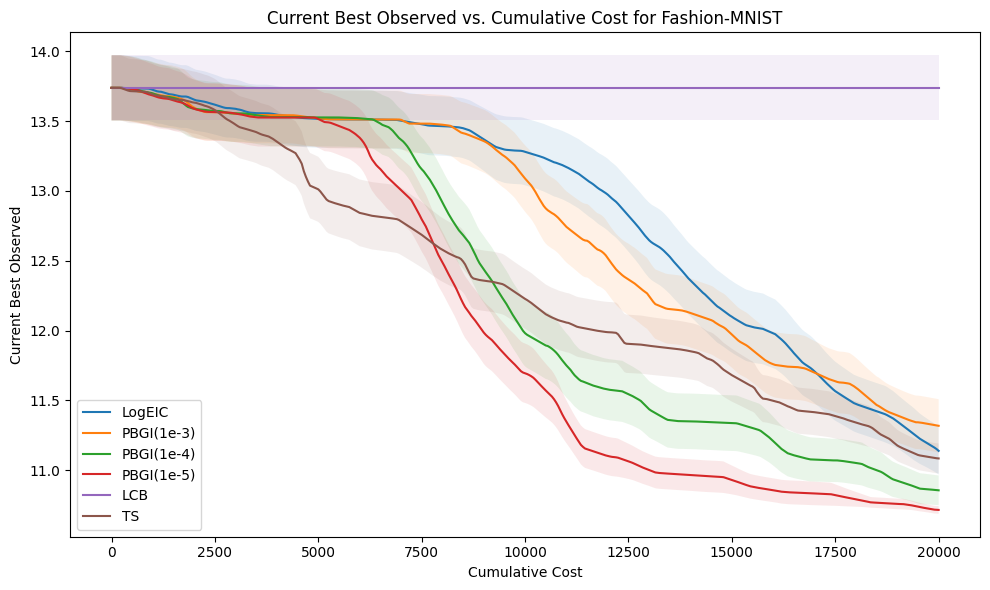

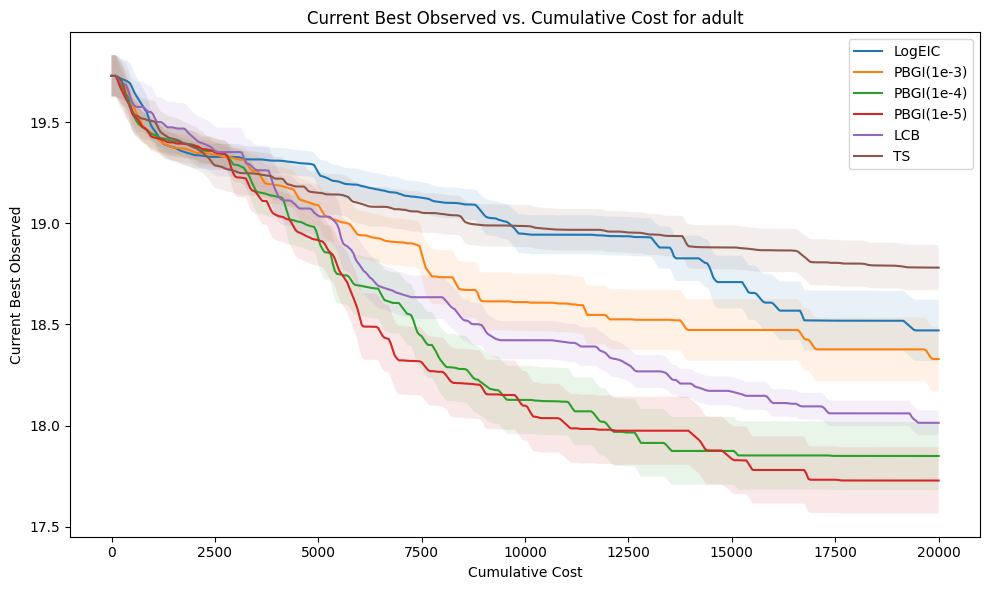

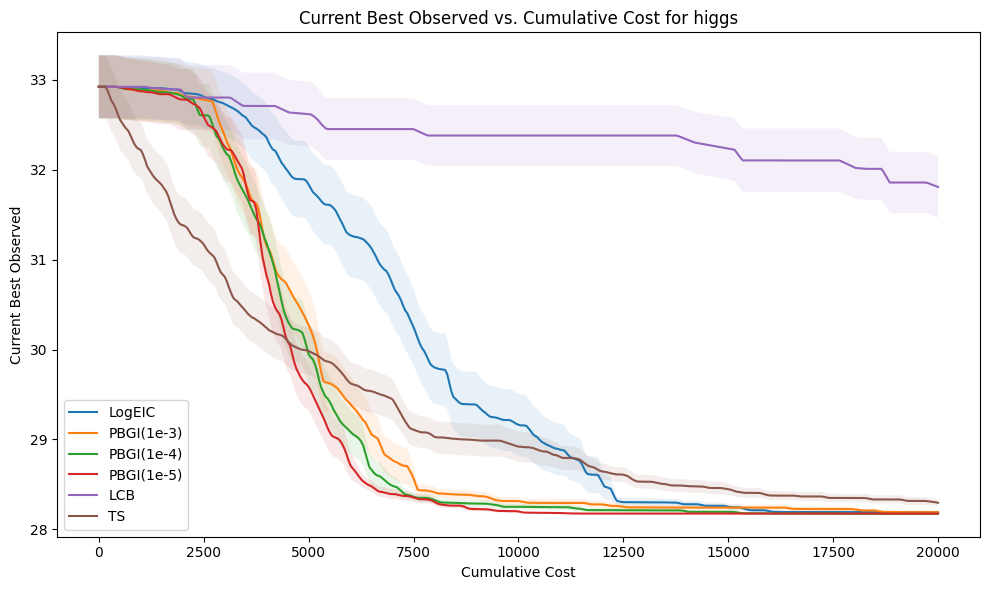

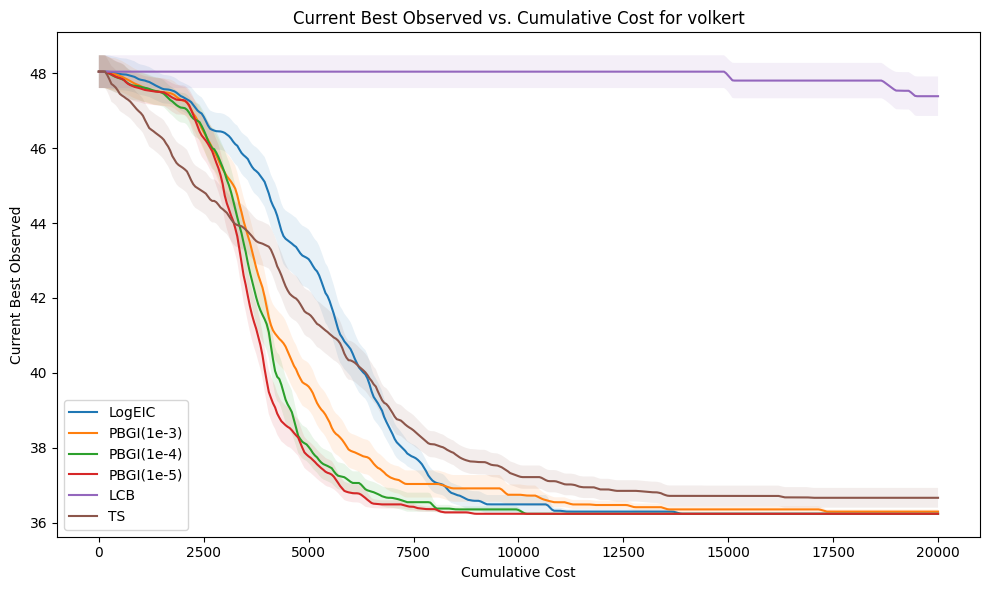

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed
        interpolated_curves = []
        
        # Access arrays from the unified structure
        cum_cost_array = metrics_per_acq[d][a]["cumulative cost"]
        best_obs_array = metrics_per_acq[d][a]["current best observed"]
        
        # Loop over each seed (assume the first dimension indexes seeds)
        for seed_id in range(len(cum_cost_array)):
            cum_cost = np.array(cum_cost_array[seed_id])
            best_obs = np.array(best_obs_array[seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            best_obs_sorted = best_obs[sort_id]
            
            # Interpolate to common cost grid
            interp_best_obs = np.interp(cost_grid, cum_cost_sorted, best_obs_sorted)
            interpolated_curves.append(interp_best_obs)
        
        # Convert to a NumPy array with shape (n_seeds, len(cost_grid))
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute mean and standard error across seeds
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize plot
    plt.title(f"Current Best Observed vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
import os
print("Current working dir:", os.getcwd())

import sys
import os

root_dir = os.path.abspath("..")
print("Adding to sys.path:", root_dir)
sys.path.insert(0, root_dir)  # Insert ensures priority

Current working dir: /Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/notebooks
Adding to sys.path: /Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt


In [7]:
import importlib.util

api_path = os.path.join(root_dir, "LCBench", "api.py")
spec = importlib.util.spec_from_file_location("LCBench.api", api_path)
api = importlib.util.module_from_spec(spec)
spec.loader.exec_module(api)

Benchmark = api.Benchmark

In [8]:
os.makedirs("../LCBench/cached", exist_ok=True)
bench_dir = "../LCBench/cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [9]:
from collections import defaultdict
import numpy as np

# Initialize unified storage for test metrics
test_metrics_per_acq = defaultdict(lambda: defaultdict(dict))

# Loop over each dataset and acquisition function.
for d in dataset_names:
    for a in acquisition_functions.values():
        # Access current best IDs from the unified structure
        best_ids = metrics_per_acq[d][a]["current best id"]
        n_seeds, n_iterations = best_ids.shape
        
        # Prepare arrays to store the test metrics
        test_error_mat = np.empty((n_seeds, n_iterations))
        
        # Use the best configuration IDs to query test metrics
        for s in range(n_seeds):
            for i in range(n_iterations):
                config_id = best_ids[s, i]
                test_error_mat[s, i] = 100-bench.query(d, "final_test_accuracy", config_id)
        
        # Store in unified structure
        test_metrics_per_acq[d][a]["final test error"] = test_error_mat

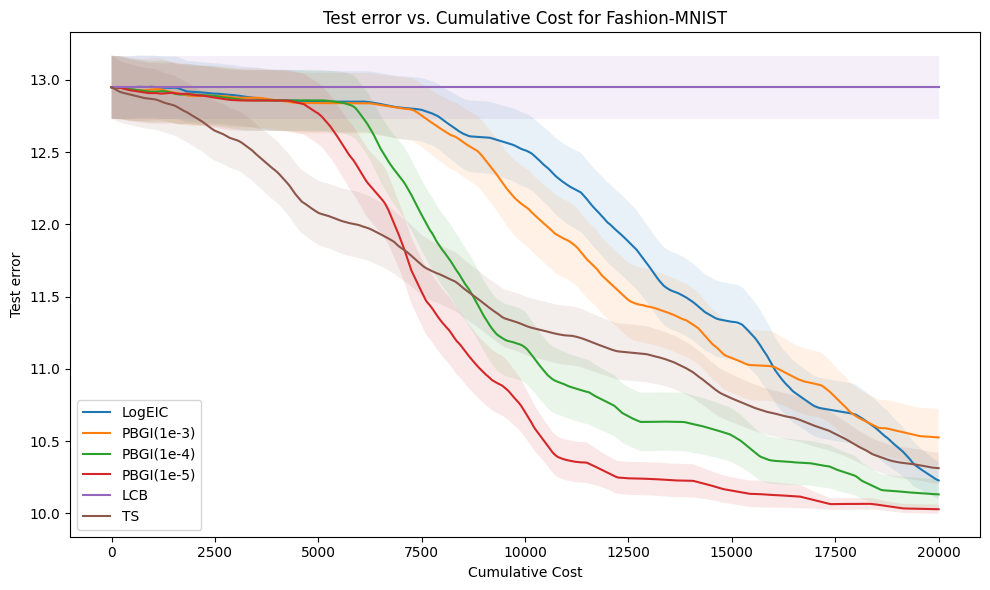

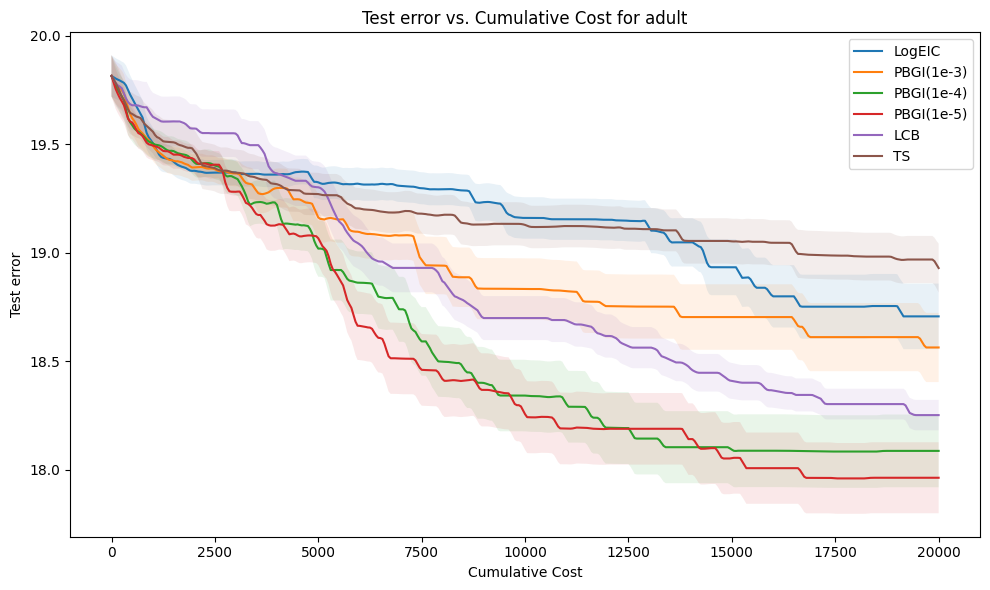

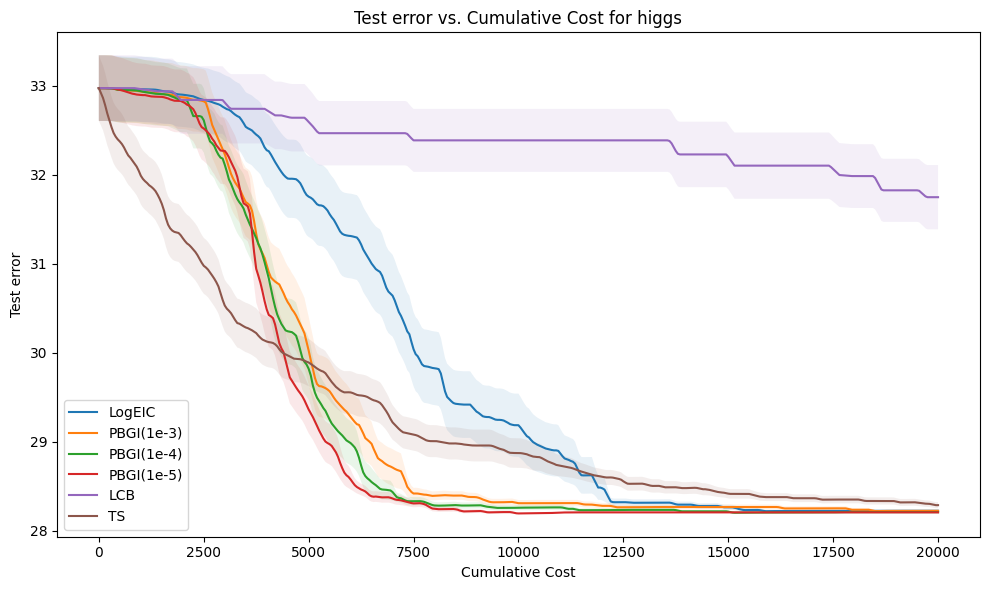

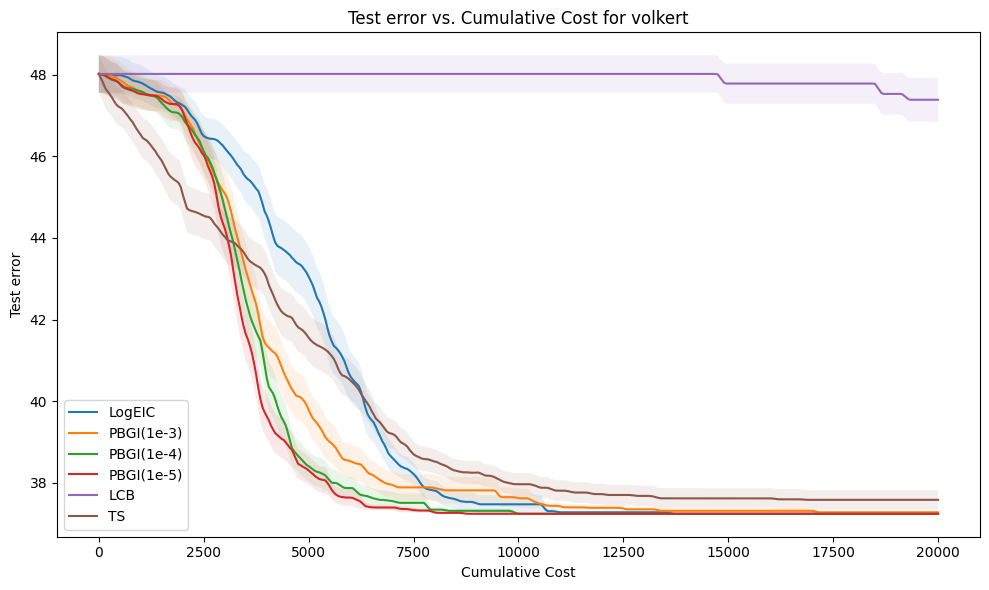

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed.
        interpolated_curves = []
        
        # Access arrays from unified structures
        cum_cost_array = metrics_per_acq[d][a]["cumulative cost"]
        test_error_array = test_metrics_per_acq[d][a]["final test error"]
        
        # Loop over each seed (assuming the first dimension indexes seeds).
        for seed_id in range(len(cum_cost_array)):
            cum_cost = np.array(cum_cost_array[seed_id])
            test_error = np.array(test_error_array[seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            test_error_sorted = test_error[sort_id]
            
            # Interpolate test CE to the common cost grid
            interp_test_error = np.interp(cost_grid, cum_cost_sorted, test_error_sorted)
            interpolated_curves.append(interp_test_error)
        
        # Stack curves and compute statistics
        interpolated_curves = np.array(interpolated_curves)
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Final touches
    plt.title(f"Test error vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Test error")
    plt.legend()
    plt.tight_layout()
    plt.show()

[Fashion-MNIST] PBGI(1e-3) + PBGI(1e-3) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-4) + PBGI(1e-4) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-3) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-4) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] LCB + UCB-LCB — No-stop count: 50 / 50
[Fashion-MNIST] TS + PRB — No-stop count: 6 / 50


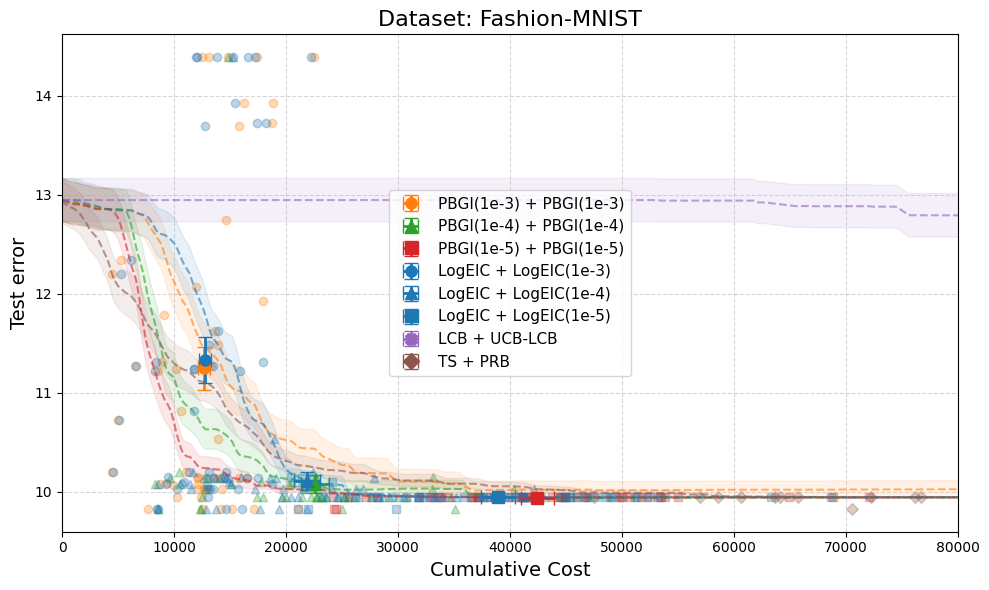

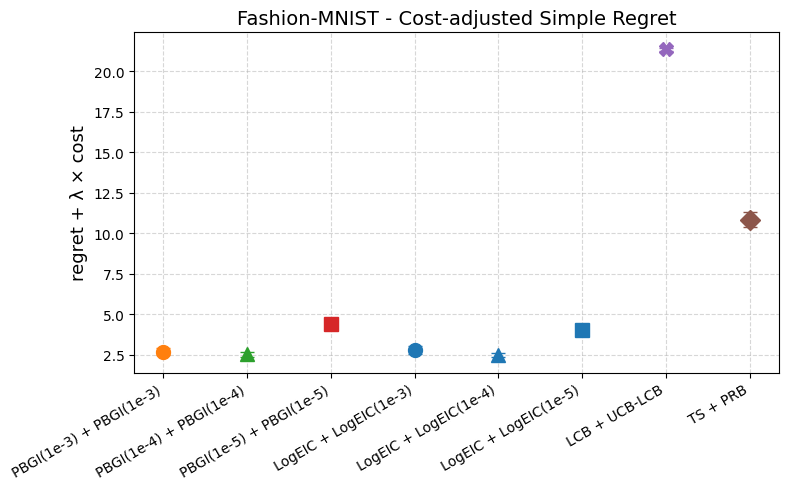

[adult] PBGI(1e-3) + PBGI(1e-3) — No-stop count: 2 / 50
[adult] PBGI(1e-4) + PBGI(1e-4) — No-stop count: 5 / 50
[adult] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 8 / 50
[adult] LogEIC + LogEIC(1e-3) — No-stop count: 1 / 50
[adult] LogEIC + LogEIC(1e-4) — No-stop count: 5 / 50
[adult] LogEIC + LogEIC(1e-5) — No-stop count: 8 / 50
[adult] LCB + UCB-LCB — No-stop count: 50 / 50
[adult] TS + PRB — No-stop count: 28 / 50


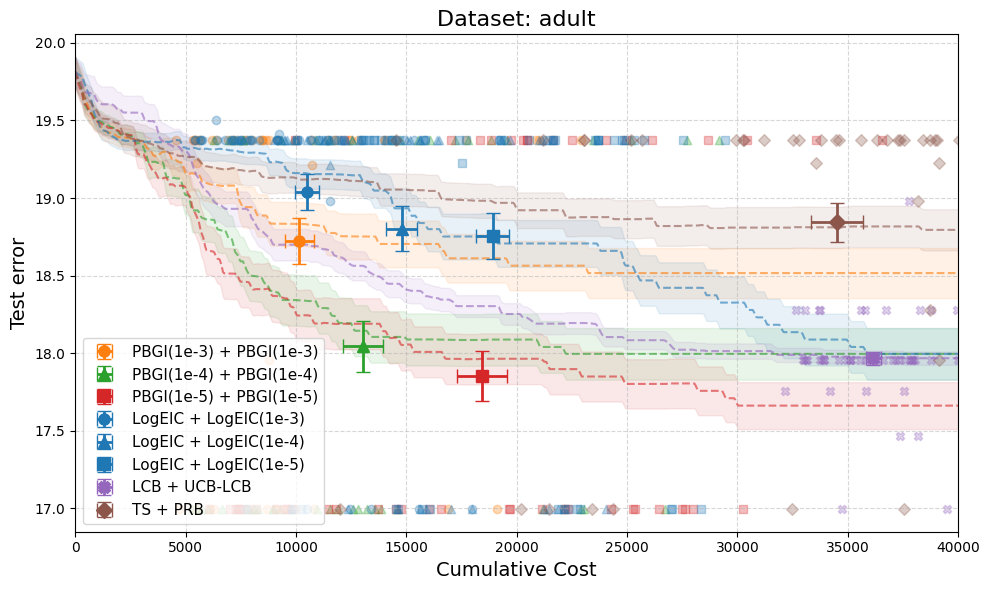

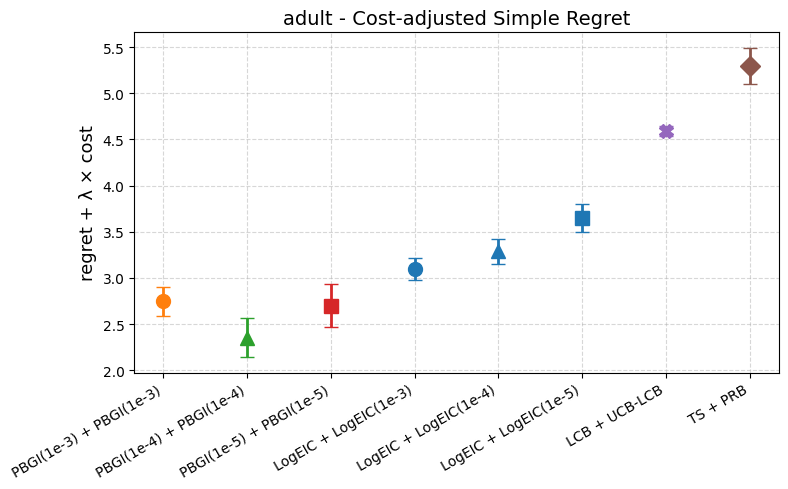

[higgs] PBGI(1e-3) + PBGI(1e-3) — No-stop count: 0 / 50
[higgs] PBGI(1e-4) + PBGI(1e-4) — No-stop count: 0 / 50
[higgs] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-3) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-4) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-5) — No-stop count: 1 / 50
[higgs] LCB + UCB-LCB — No-stop count: 50 / 50
[higgs] TS + PRB — No-stop count: 7 / 50


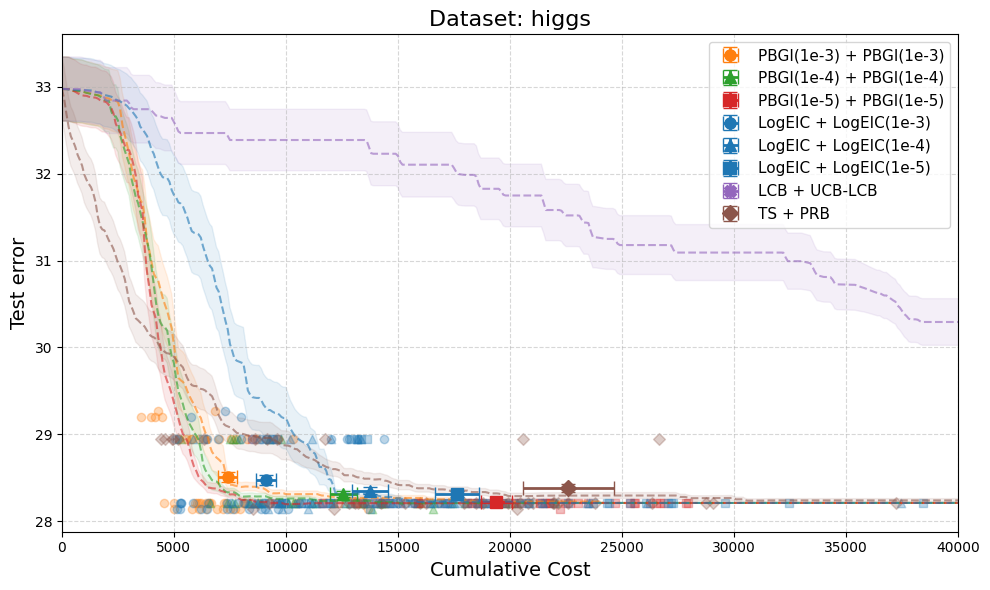

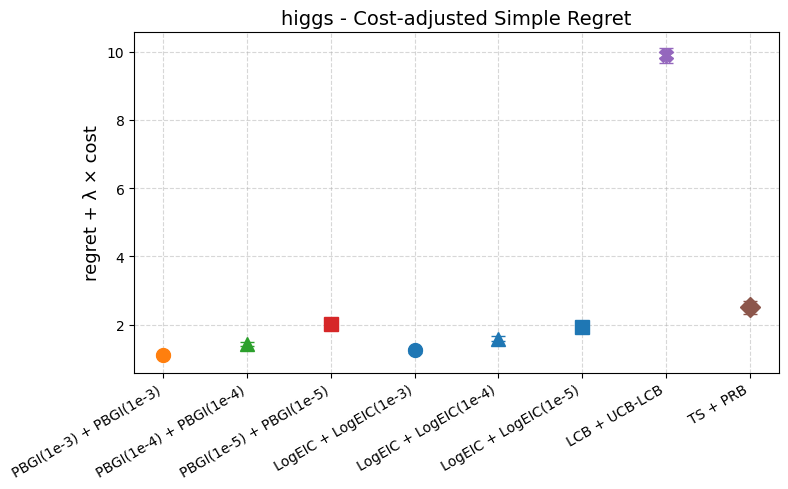

[volkert] PBGI(1e-3) + PBGI(1e-3) — No-stop count: 0 / 50
[volkert] PBGI(1e-4) + PBGI(1e-4) — No-stop count: 0 / 50
[volkert] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-3) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-4) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[volkert] LCB + UCB-LCB — No-stop count: 50 / 50
[volkert] TS + PRB — No-stop count: 1 / 50


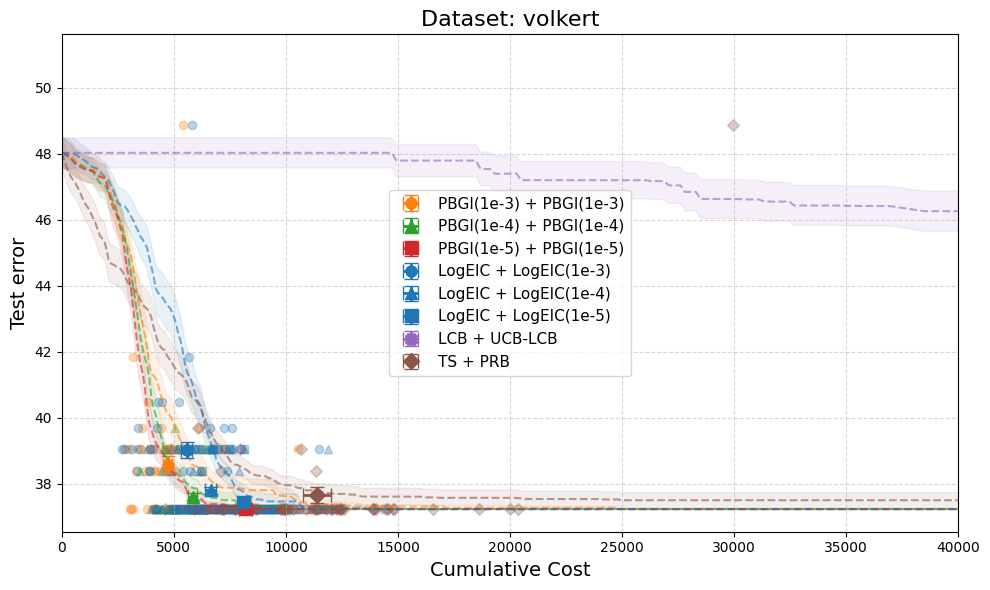

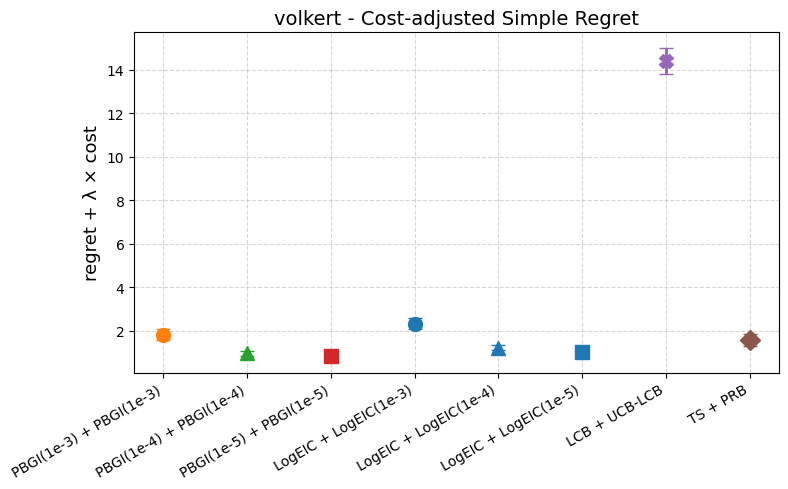

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define tab colors and markers
color_dict = {
    'PBGI(1e-3)': 'tab:orange',  
    'PBGI(1e-4)': 'tab:green',  
    'PBGI(1e-5)': 'tab:red',  
    'LogEIC': 'tab:blue',      
    'LCB': 'tab:purple',         
    'TS': 'tab:brown',          
}

marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's',
    'LCB': 'X',
    'TS': 'D'
}

# Stopping rules
stopping_rules = [
    {
        'label': 'PBGI(1e-3) + PBGI(1e-3)',
        'acq_key': 'PBGI(1e-3)',
        'color': color_dict['PBGI(1e-3)'],
        'marker': marker_dict['1e-3'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['PBGI(1e-3)']["PBGI(1e-3) acq"][seed_id][i] >=
            metrics_per_acq[d]['PBGI(1e-3)']["current best observed"][seed_id][i - 1]
        )
    },
    {
        'label': 'PBGI(1e-4) + PBGI(1e-4)',
        'acq_key': 'PBGI(1e-4)',
        'color': color_dict['PBGI(1e-4)'],
        'marker': marker_dict['1e-4'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['PBGI(1e-4)']["PBGI(1e-4) acq"][seed_id][i] >=
            metrics_per_acq[d]['PBGI(1e-4)']["current best observed"][seed_id][i - 1]
        )
    },
    {
        'label': 'PBGI(1e-5) + PBGI(1e-5)',
        'acq_key': 'PBGI(1e-5)',
        'color': color_dict['PBGI(1e-5)'],
        'marker': marker_dict['1e-5'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['PBGI(1e-5)']["PBGI(1e-5) acq"][seed_id][i] >=
            metrics_per_acq[d]['PBGI(1e-5)']["current best observed"][seed_id][i - 1]
        )
    },
    {
        'label': 'LogEIC + LogEIC(1e-3)',
        'acq_key': 'LogEIC',
        'color': color_dict['LogEIC'],
        'marker': marker_dict['1e-3'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['LogEIC']["LogEIC acq"][seed_id][i] <= np.log(1e-3)
        )
    },
    {
        'label': 'LogEIC + LogEIC(1e-4)',
        'acq_key': 'LogEIC',
        'color': color_dict['LogEIC'],
        'marker': marker_dict['1e-4'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['LogEIC']["LogEIC acq"][seed_id][i] <= np.log(1e-4)
        )
    },
    {
        'label': 'LogEIC + LogEIC(1e-5)',
        'acq_key': 'LogEIC',
        'color': color_dict['LogEIC'],
        'marker': marker_dict['1e-5'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['LogEIC']["LogEIC acq"][seed_id][i] <= np.log(1e-5)
        )
    },
    {
        'label': 'LCB + UCB-LCB',
        'acq_key': 'LCB',
        'color': color_dict['LCB'],
        'marker': marker_dict['LCB'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['LCB']["regret upper bound"][seed_id][i] <= 0.01
        )
    },
    {
        'label': 'TS + PRB',
        'acq_key': 'TS',
        'color': color_dict['TS'],
        'marker': marker_dict['TS'],
        'condition_fn': lambda i, seed_id, d: (
            metrics_per_acq[d]['TS']["PRB"][seed_id][i] >= 0.95
        )
    },
]

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult": 40000,
    "higgs": 40000,
    "volkert": 40000
}

cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult": 40000,
    "higgs": 80000,
    "volkert": 80000
}


lmbda = 1e-4

for d in dataset_names:
    cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
    plt.figure(figsize=(10, 6))
    plotted_curves = set()
    cost_adjusted_simple_regret = {rule['label']: [] for rule in stopping_rules}

    best_test_error = 100-bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)

    for rule in stopping_rules:
        acq_key = rule['acq_key']
        label = rule['label']
        color = rule['color']
        marker = rule['marker']

        # Plot mean test error curve for the acquisition function if not already plotted
        if acq_key not in plotted_curves:
            interpolated_curves = []
            error_array = test_metrics_per_acq[d][acq_key]["final test error"]
            cost_array = metrics_per_acq[d][acq_key]["cumulative cost"]

            for seed_id in range(len(error_array)):
                cost = cost_array[seed_id]
                err = error_array[seed_id]
                sort_id = np.argsort(cost)
                interp_error = np.interp(cost_grid, cost[sort_id], err[sort_id])
                interpolated_curves.append(interp_error)

            interpolated_curves = np.array(interpolated_curves)
            mean_error = np.mean(interpolated_curves, axis=0)
            sem_error = np.std(interpolated_curves, axis=0) / np.sqrt(len(interpolated_curves))

            plt.plot(cost_grid, mean_error, linestyle='--', color=color, alpha=0.6)
            plt.fill_between(cost_grid, mean_error - sem_error, mean_error + sem_error, color=color, alpha=0.1)
            plotted_curves.add(acq_key)

        # Stopping rule evaluation
        stop_costs, stop_test_error = [], []
        error_array = test_metrics_per_acq[d][acq_key]["final test error"]
        cost_array = metrics_per_acq[d][acq_key]["cumulative cost"]
        n_seeds = len(error_array)
        no_stop_count = 0

        for seed_id in range(n_seeds):
            err = error_array[seed_id]
            cost = cost_array[seed_id]

            if len(err) < 20:
                stop_id = len(err) - 1
            else:
                try:
                    stop_id = next(i for i in range(20, len(err)) if rule['condition_fn'](i, seed_id, d))
                except StopIteration:
                    stop_id = len(err) - 1
                    no_stop_count += 1

            stop_costs.append(cost[stop_id])
            stop_test_error.append(err[stop_id])
            regret = err[stop_id] - best_test_error + lmbda * cost[stop_id]
            cost_adjusted_simple_regret[label].append(regret)

        print(f"[{d}] {label} — No-stop count: {no_stop_count} / {n_seeds}")

        # Plot stopping points with error bars
        stop_costs = np.array(stop_costs)
        stop_test_error = np.array(stop_test_error)
        plt.scatter(stop_costs, stop_test_error, color=color, alpha=0.3, marker=marker)

        mx, my = np.mean(stop_costs), np.mean(stop_test_error)
        sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
        sy = np.std(stop_test_error) / np.sqrt(len(stop_test_error))
        plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=marker, color=color,
                     markersize=8, capsize=5, linewidth=2, label=label)

    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test error", fontsize=14)
    plt.title(f"Dataset: {d}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, x_limit_per_dataset[d])
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Cost-adjusted simple regret summary plot
    plt.figure(figsize=(8, 5))
    for rule in stopping_rules:
        label = rule['label']
        regrets = cost_adjusted_simple_regret[label]
        if regrets:
            regrets = np.array(regrets)
            plt.errorbar([label], [np.mean(regrets)],
                         yerr=[np.std(regrets) / np.sqrt(len(regrets))],
                         fmt=rule['marker'], color=rule['color'], capsize=5,
                         markersize=10, linewidth=2)

    plt.xticks(rotation=30, ha='right')
    plt.ylabel("regret + λ × cost", fontsize=13)
    plt.title(f"{d} - Cost-adjusted Simple Regret", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

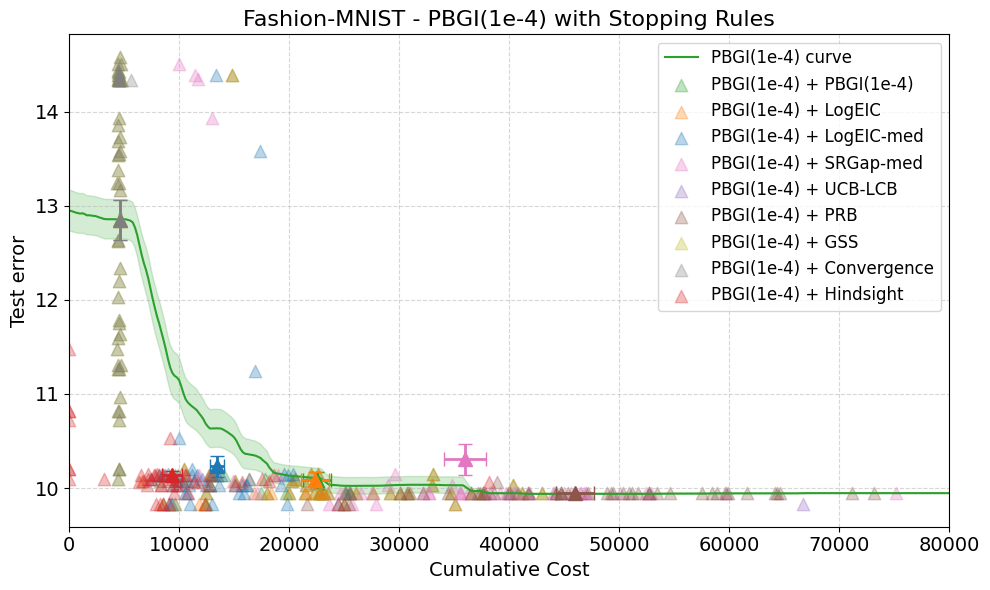

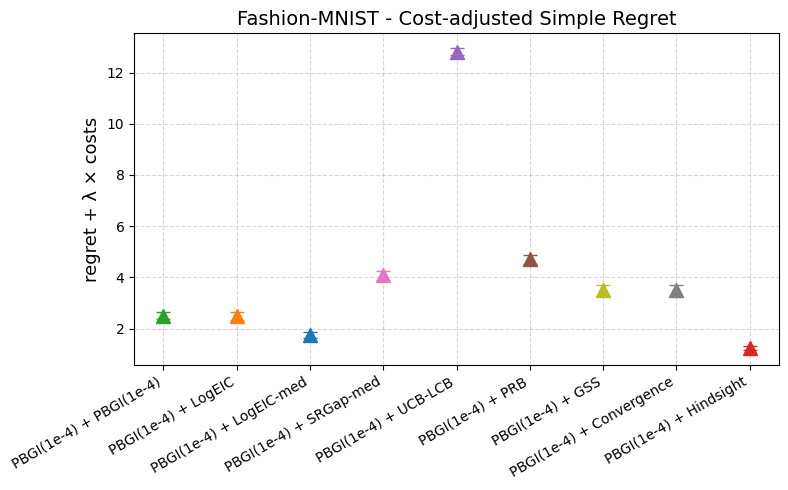

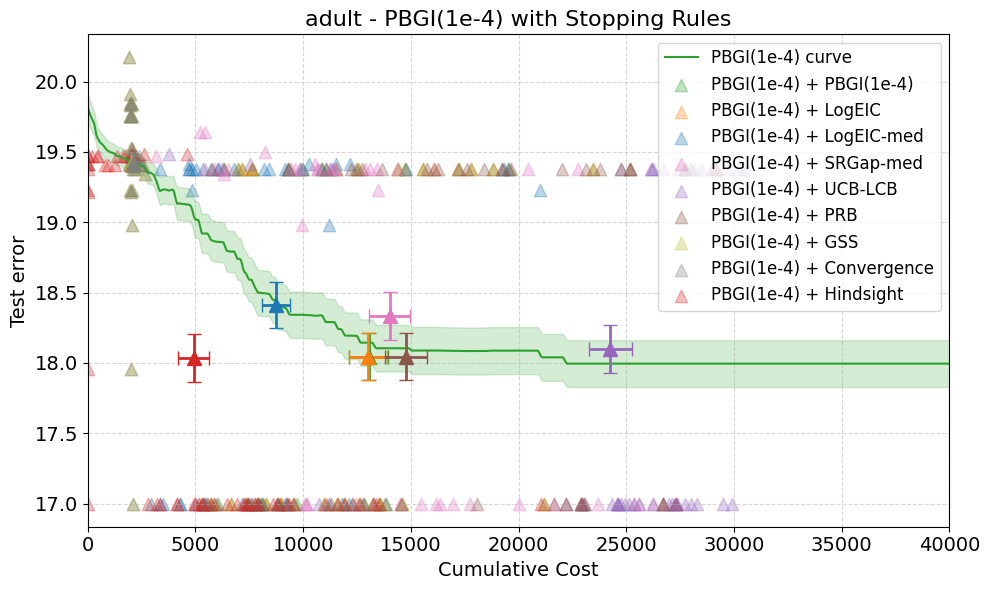

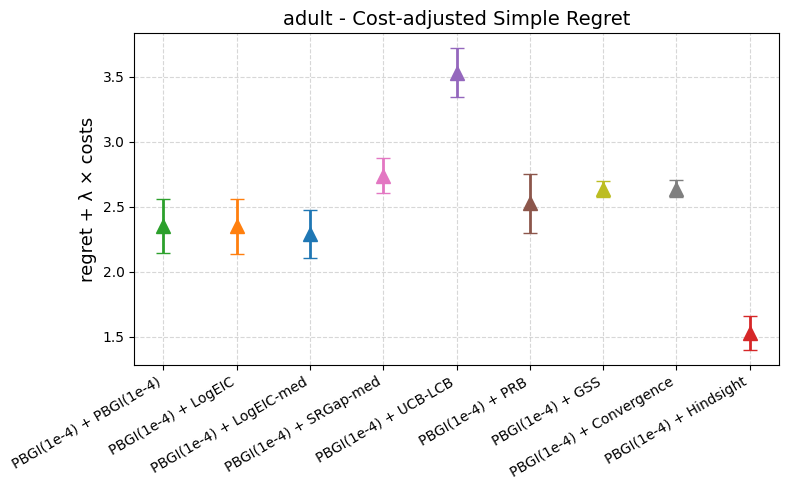

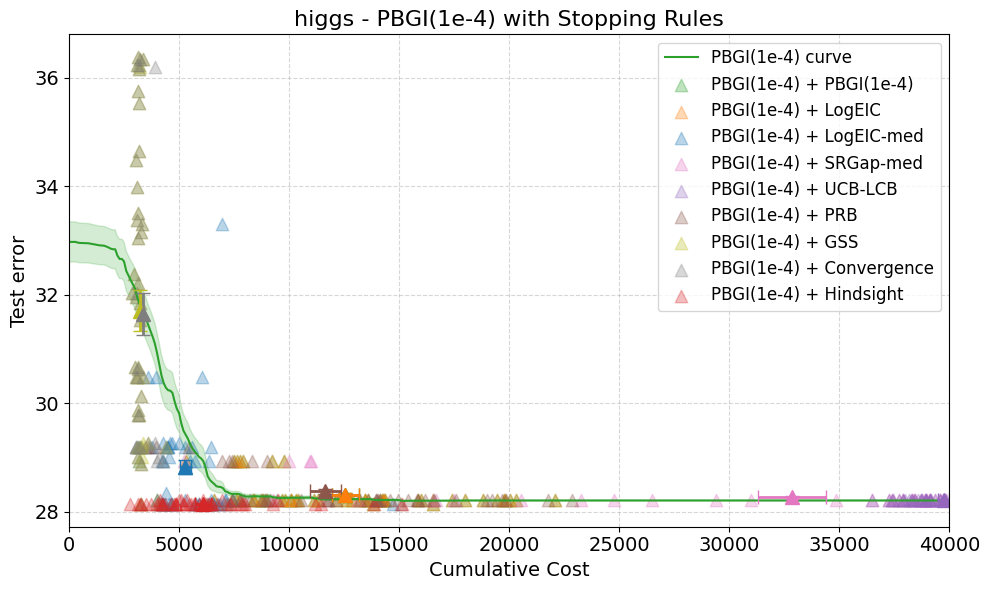

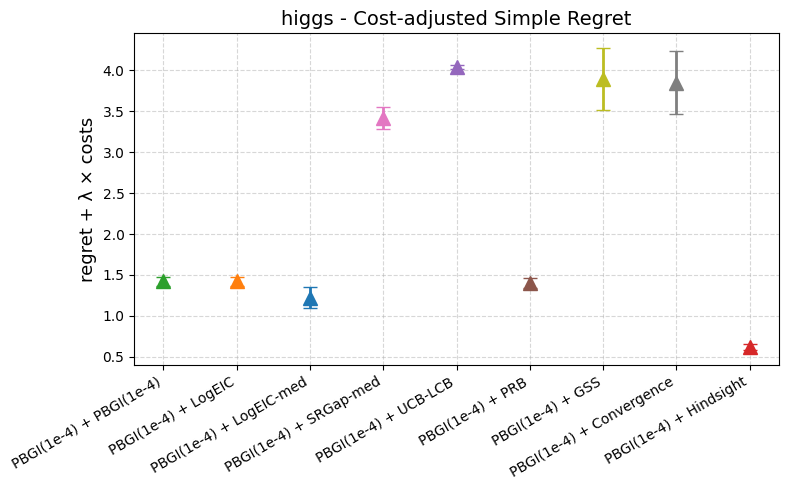

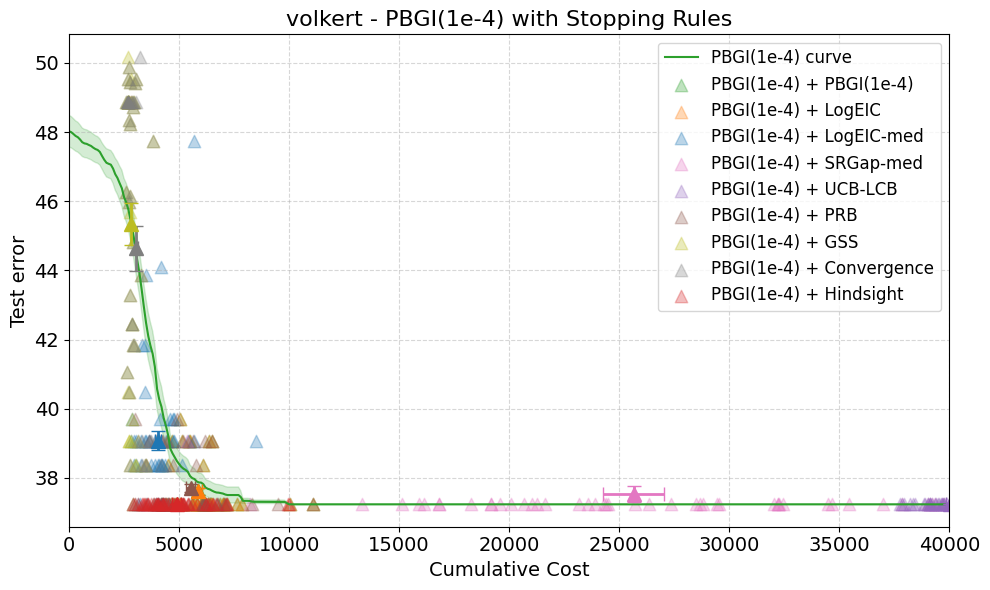

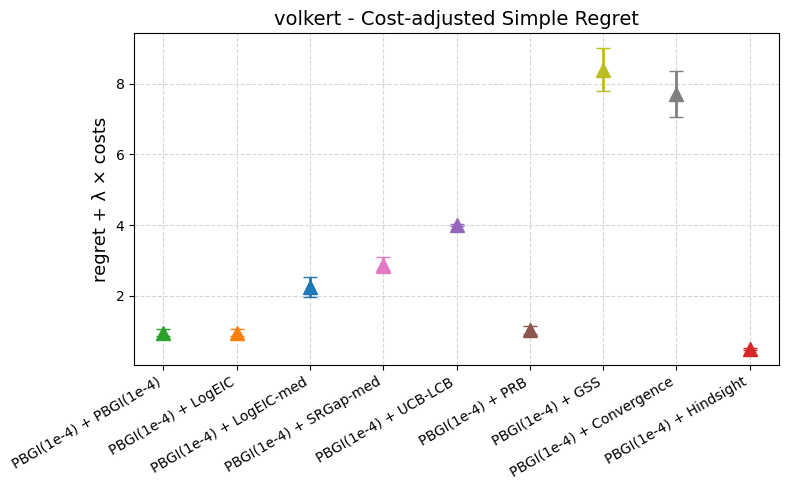

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# === Config ===

# Color and marker settings
color_dict = {
    'PBGI(1e-4)': 'tab:green',
    'LogEIC': 'tab:orange',
    'LogEIC-med': 'tab:blue',
    'UCB-LCB': 'tab:purple',
    'SRGap-med': 'tab:pink',
    'PRB': 'tab:brown',
    'GSS': 'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight': 'tab:red'
}

marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's'
}

# Fixed acquisition function and init
fixed_acq = 'PBGI(1e-4)'
init = 20
lmbda = 1e-4

# === Define stopping rules ===

stopping_rules = [
    {
        'acq_key': fixed_acq, 'stp_key': fixed_acq, 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict[fixed_acq],
        'condition_fn': lambda i, seed, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["PBGI(1e-4) acq"][seed][i] >=
            metrics_per_acq[d][fixed_acq]["current best observed"][seed][i - 1]
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'LogEIC', 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict['LogEIC'],
        'condition_fn': lambda i, seed, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["LogEIC acq"][seed][i] <= np.log(1e-4)
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'LogEIC-med', 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict['LogEIC-med'],
        'condition_fn': lambda i, seed, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["LogEIC acq"][seed][i] <= (
                np.log(0.01) + np.nanmedian(metrics_per_acq[d][fixed_acq]["LogEIC acq"][seed][1:21])
            )
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'SRGap-med', 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict['SRGap-med'],
        'condition_fn': lambda i, seed, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["exp min regret gap"][seed][i] <=
            0.1 * np.nanmedian(metrics_per_acq[d][fixed_acq]["exp min regret gap"][seed][1:21])
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'UCB-LCB',
        'marker': marker_dict['1e-4'],
        'color': color_dict['UCB-LCB'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["regret upper bound"][seed_id][i] <= 0.01
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'PRB',
        'marker': marker_dict['1e-4'],
        'color': color_dict['PRB'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["PRB"][seed_id][i] >= 0.95
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'GSS', 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict['GSS'],
        'condition_fn': lambda i, seed, d: (
            i >= init and (
                (np.nanpercentile(metrics_per_acq[d][fixed_acq]["current best observed"][seed][:i+1], 75) -
                 np.nanpercentile(metrics_per_acq[d][fixed_acq]["current best observed"][seed][:i+1], 25)) == 0 or
                (
                    (metrics_per_acq[d][fixed_acq]["current best observed"][seed][i - 5] -
                     metrics_per_acq[d][fixed_acq]["current best observed"][seed][i]) /
                    (np.nanpercentile(metrics_per_acq[d][fixed_acq]["current best observed"][seed][:i+1], 75) -
                     np.nanpercentile(metrics_per_acq[d][fixed_acq]["current best observed"][seed][:i+1], 25))
                ) <= 0.01
            )
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'Convergence', 'is_hindsight': False,
        'marker': marker_dict['1e-4'], 'color': color_dict['Convergence'],
        'condition_fn': lambda i, seed, d: (
            i >= init and
            metrics_per_acq[d][fixed_acq]["current best observed"][seed][i] ==
            metrics_per_acq[d][fixed_acq]["current best observed"][seed][i - 5]
        )
    },
    {
        'acq_key': fixed_acq, 'stp_key': 'Hindsight', 'is_hindsight': True,
        'marker': marker_dict['1e-4'], 'color': color_dict['Hindsight'],
    }
]

for rule in stopping_rules:
    rule['label'] = f"{rule['acq_key']} + {rule['stp_key']}"

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult": 40000,
    "higgs": 40000,
    "volkert": 40000
}

cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult": 40000,
    "higgs": 80000,
    "volkert": 80000
}

# === Run analysis per dataset ===

for d in dataset_names:
    cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
    plt.figure(figsize=(10, 6))
    error_array = test_metrics_per_acq[d][fixed_acq]["final test error"]
    cost_array = metrics_per_acq[d][fixed_acq]["cumulative cost"]
    best_test_error = 100-bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)

    # Plot mean test error curve
    interpolated_curves = [
        np.interp(cost_grid, np.array(cost_array[seed])[np.argsort(cost_array[seed])],
                  np.array(error_array[seed])[np.argsort(cost_array[seed])])
        for seed in range(len(error_array))
    ]
    interpolated_curves = np.array(interpolated_curves)
    mean_curve = np.mean(interpolated_curves, axis=0)
    sem_curve = np.std(interpolated_curves, axis=0) / np.sqrt(len(interpolated_curves))

    plt.plot(cost_grid, mean_curve, label=f"{fixed_acq} curve", color=color_dict[fixed_acq])
    plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, color=color_dict[fixed_acq], alpha=0.2)

    # Init collectors
    stopping_counts = {rule['label']: 0 for rule in stopping_rules}
    cost_adjusted_simple_regret = {rule['label']: [] for rule in stopping_rules}

    for rule in stopping_rules:
        stop_costs, stop_test_error = [], []
        acq_key = rule['acq_key']
        label = rule['label']

        error_array = test_metrics_per_acq[d][acq_key]["final test error"]
        cost_array = metrics_per_acq[d][acq_key]["cumulative cost"]
        n_seeds = len(error_array)

        for seed_id in range(n_seeds):
            test_error = error_array[seed_id]
            cost = cost_array[seed_id]

            if rule['is_hindsight']:
                regret_arr = test_error - best_test_error + lmbda * cost
                stop_id = np.argmin(regret_arr)
            else:
                stop_id = next((i for i in range(init, len(test_error)) if rule['condition_fn'](i, seed_id, d)), None)
                if stop_id is None:
                    stop_id = len(test_error) - 1  # Use last point if no stop

            # Always record, even if it's from the fallback
            stop_costs.append(cost[stop_id])
            stop_test_error.append(test_error[stop_id])
            regret = test_error[stop_id] - best_test_error + lmbda * cost[stop_id]
            cost_adjusted_simple_regret[label].append(regret)

            if not rule['is_hindsight'] and stop_id != len(test_error) - 1:
                stopping_counts[label] += 1

        # Plot
        stop_costs = np.array(stop_costs)
        stop_test_error = np.array(stop_test_error)
        plt.scatter(stop_costs, stop_test_error, color=rule['color'], alpha=0.3,
                    marker=rule['marker'], s=80, label=label)

        mx, my = np.mean(stop_costs), np.mean(stop_test_error)
        sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
        sy = np.std(stop_test_error) / np.sqrt(len(stop_test_error))
        plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=rule['marker'], color=rule['color'],
                    markersize=10, capsize=5, linewidth=2)

    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test error", fontsize=14)
    plt.title(f"{d} - {fixed_acq} with Stopping Rules", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, x_limit_per_dataset[d])
    plt.tight_layout()
    plt.show()

    # === Cost-adjusted simple regret summary ===
    plt.figure(figsize=(8, 5))
    for rule in stopping_rules:
        if rule['acq_key'] != fixed_acq:
            continue
        label = rule['label']
        values = cost_adjusted_simple_regret[label]
        if values:
            values = np.array(values)
            mean_val = np.mean(values)
            err = np.std(values) / np.sqrt(len(values))
            plt.errorbar([label], [mean_val], yerr=[err], fmt=rule['marker'], color=rule['color'],
                         capsize=5, markersize=10, linewidth=2)

    plt.xticks(rotation=30, ha='right')
    plt.ylabel("regret + λ × costs", fontsize=13)
    plt.title(f"{d} - Cost-adjusted Simple Regret", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

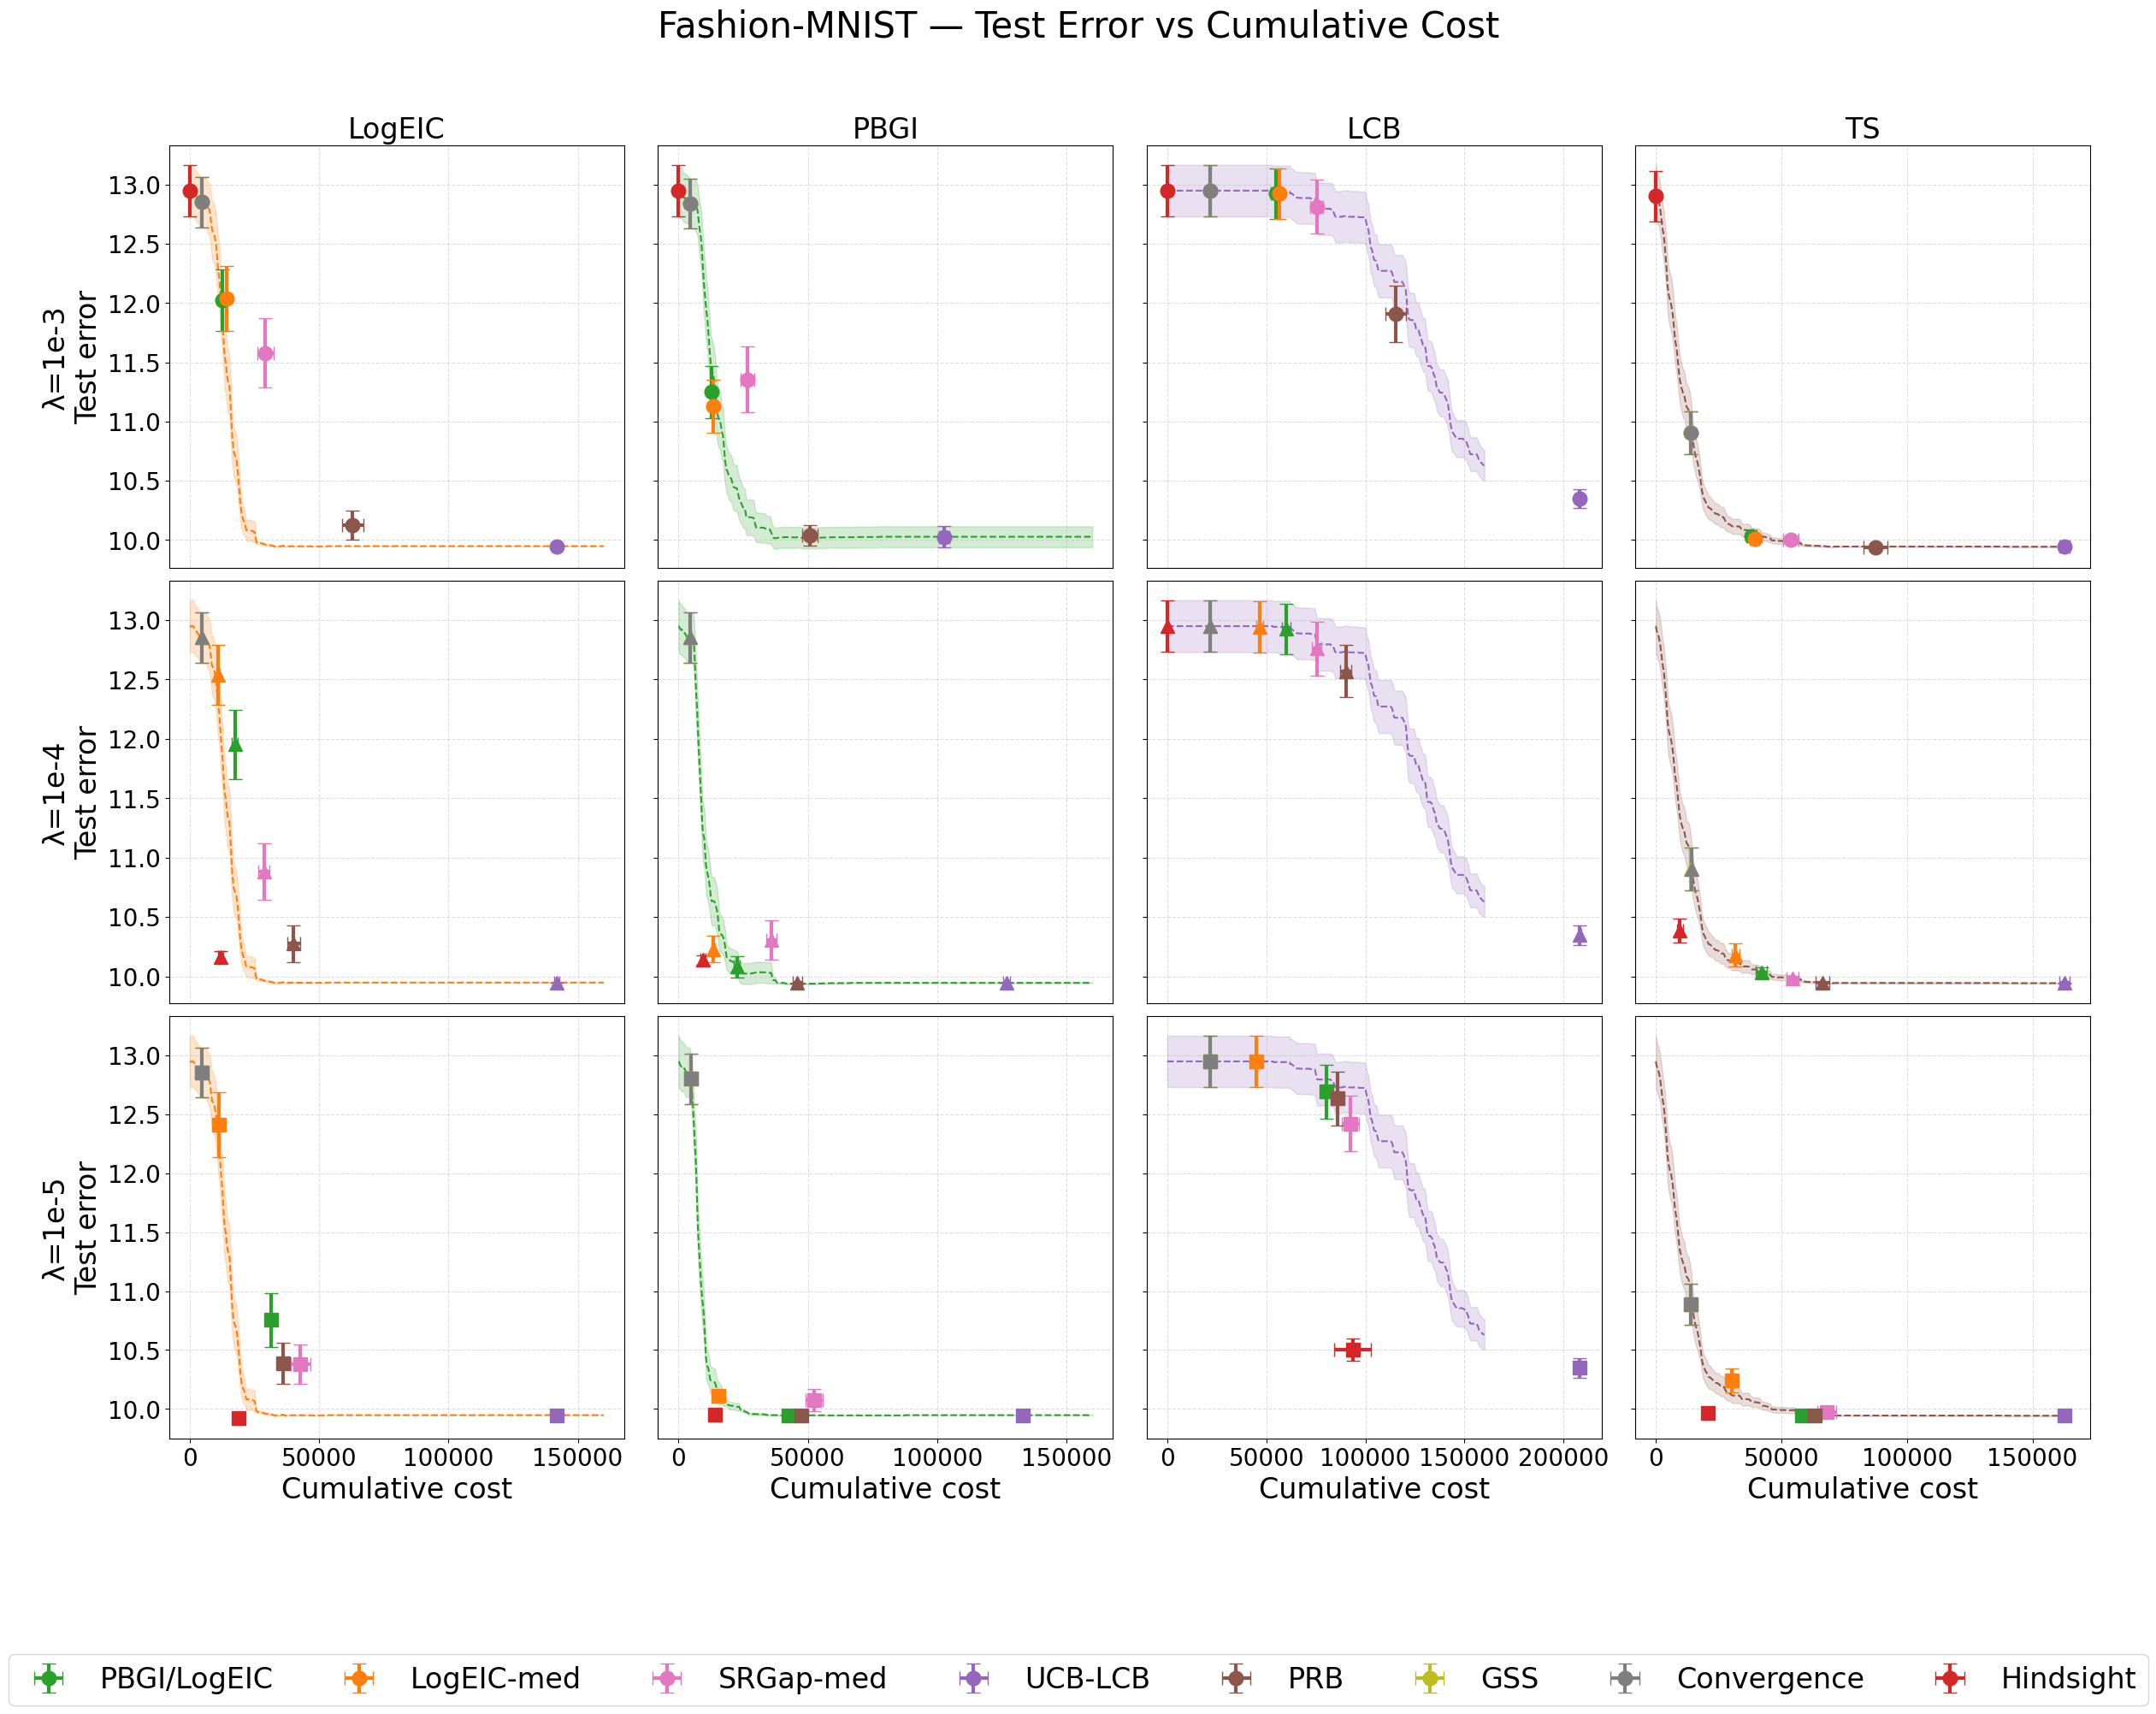

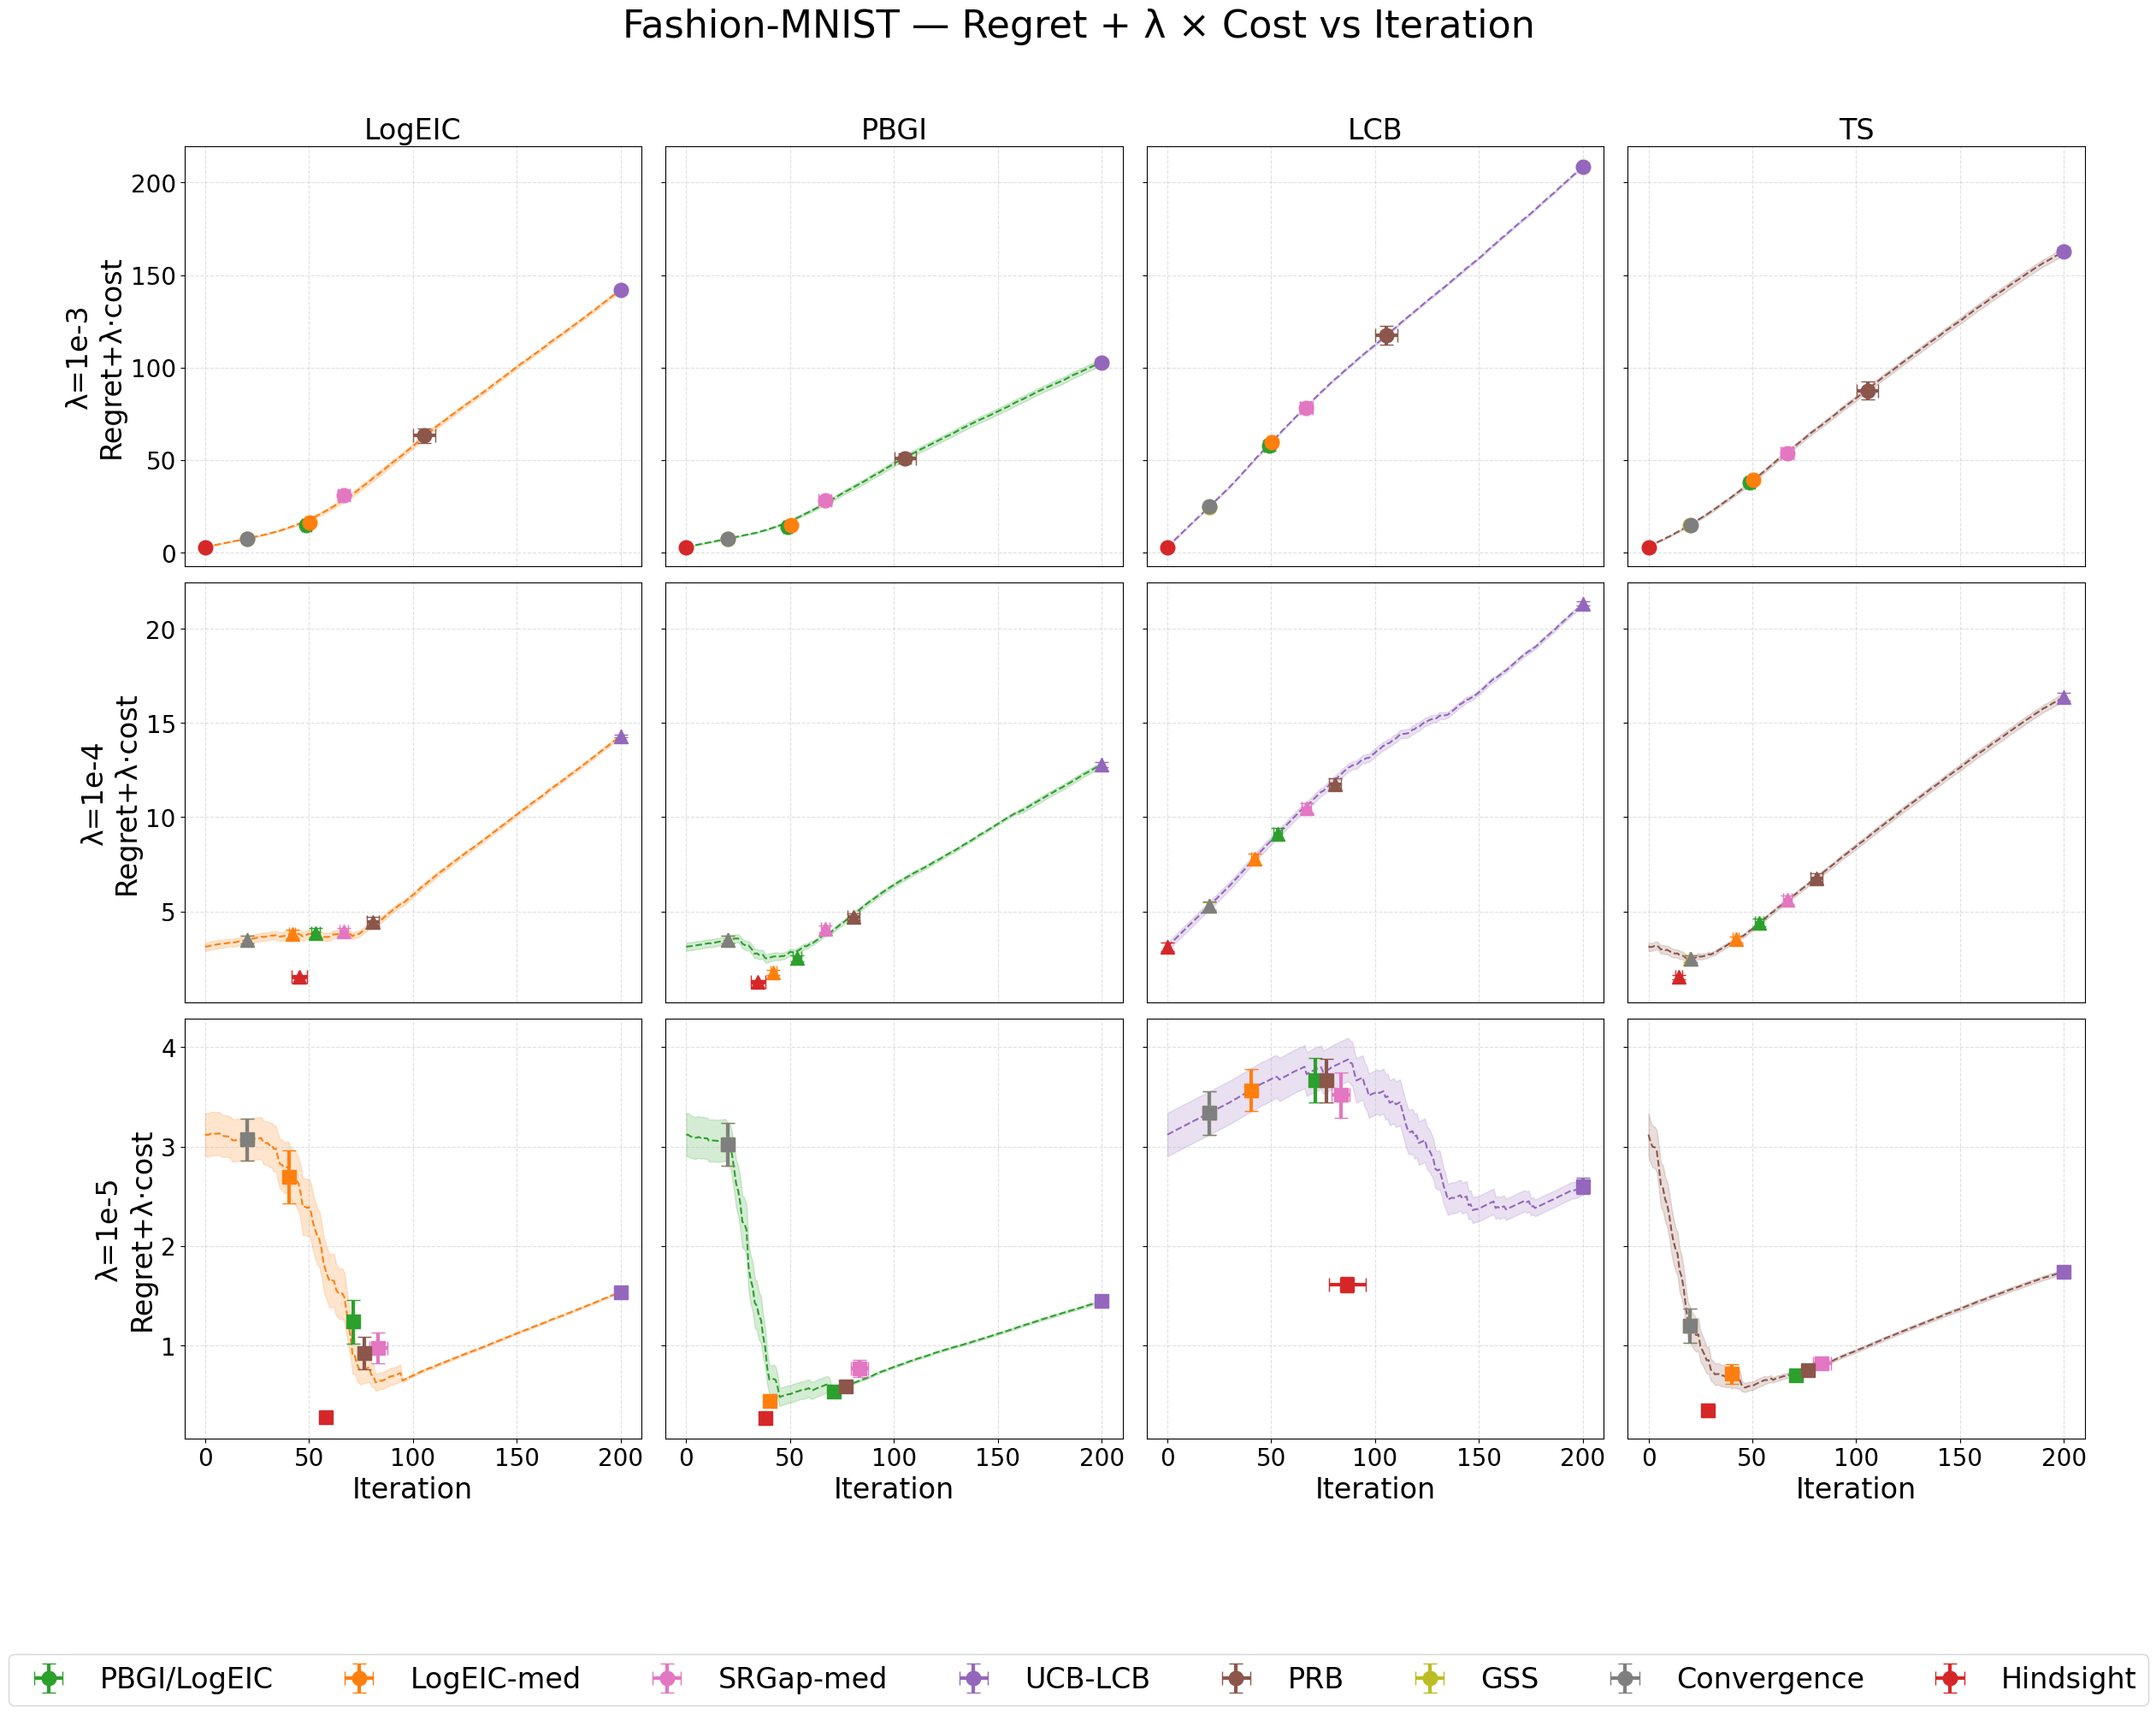

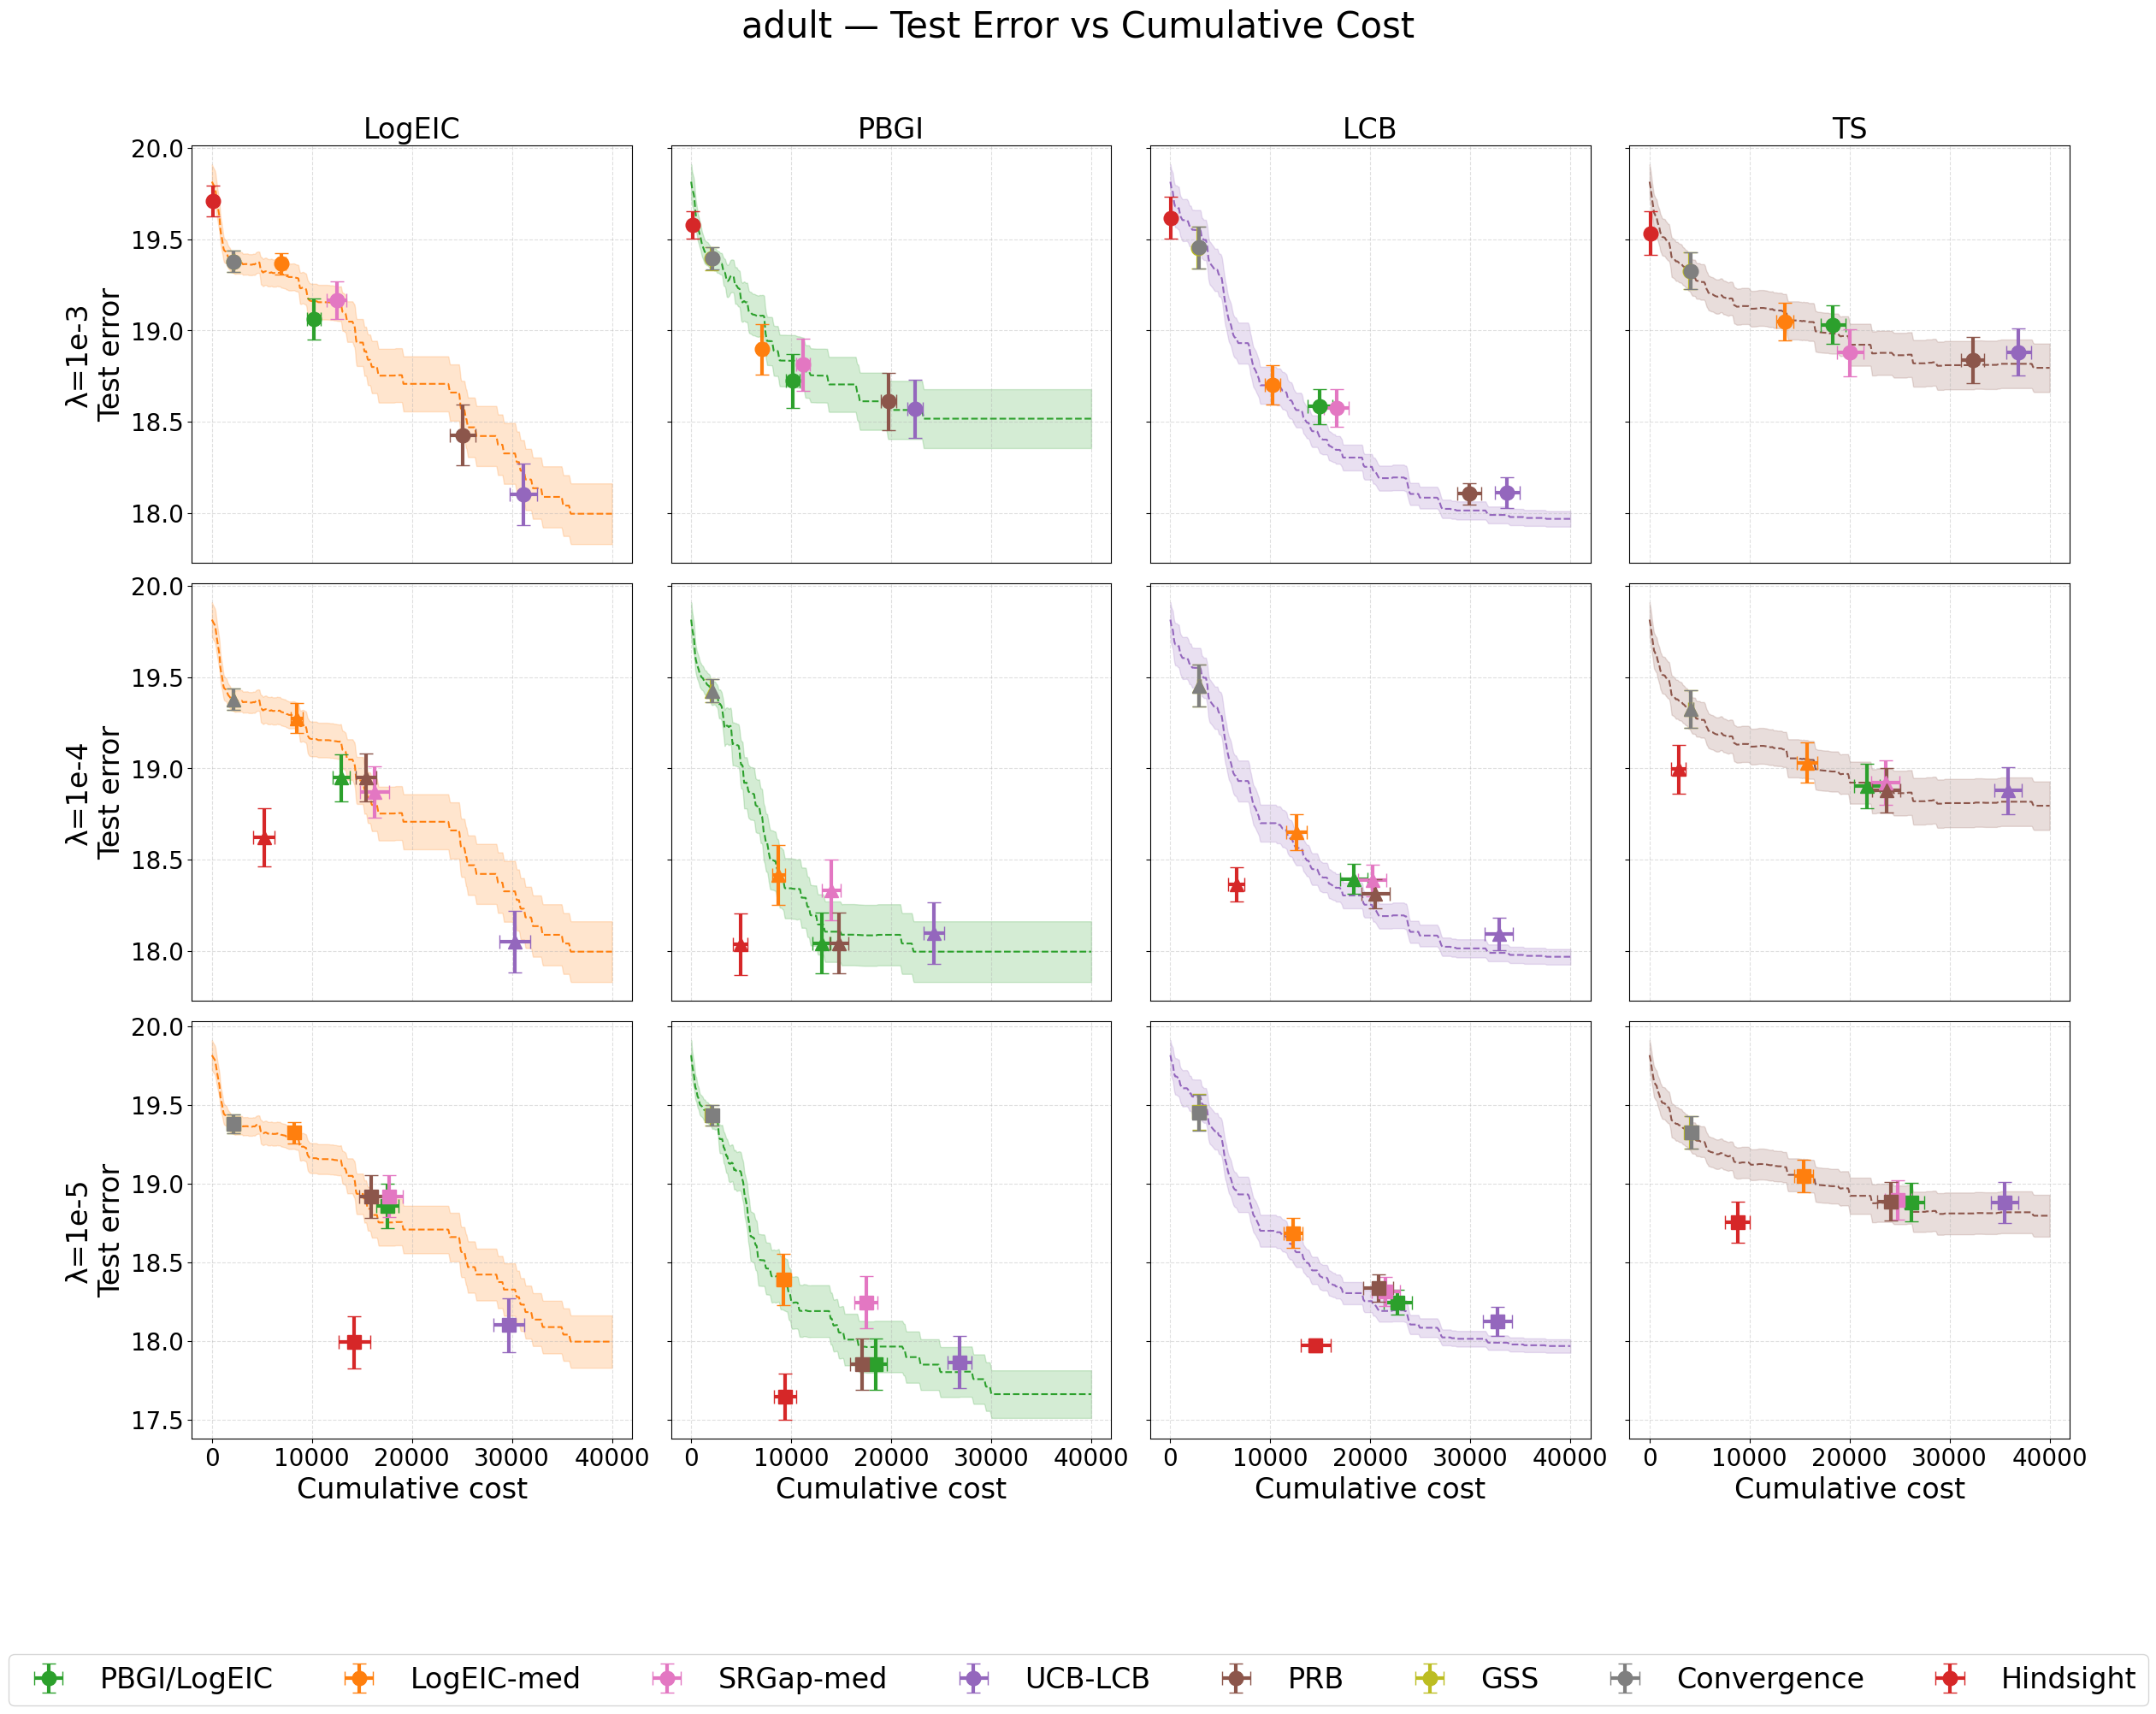

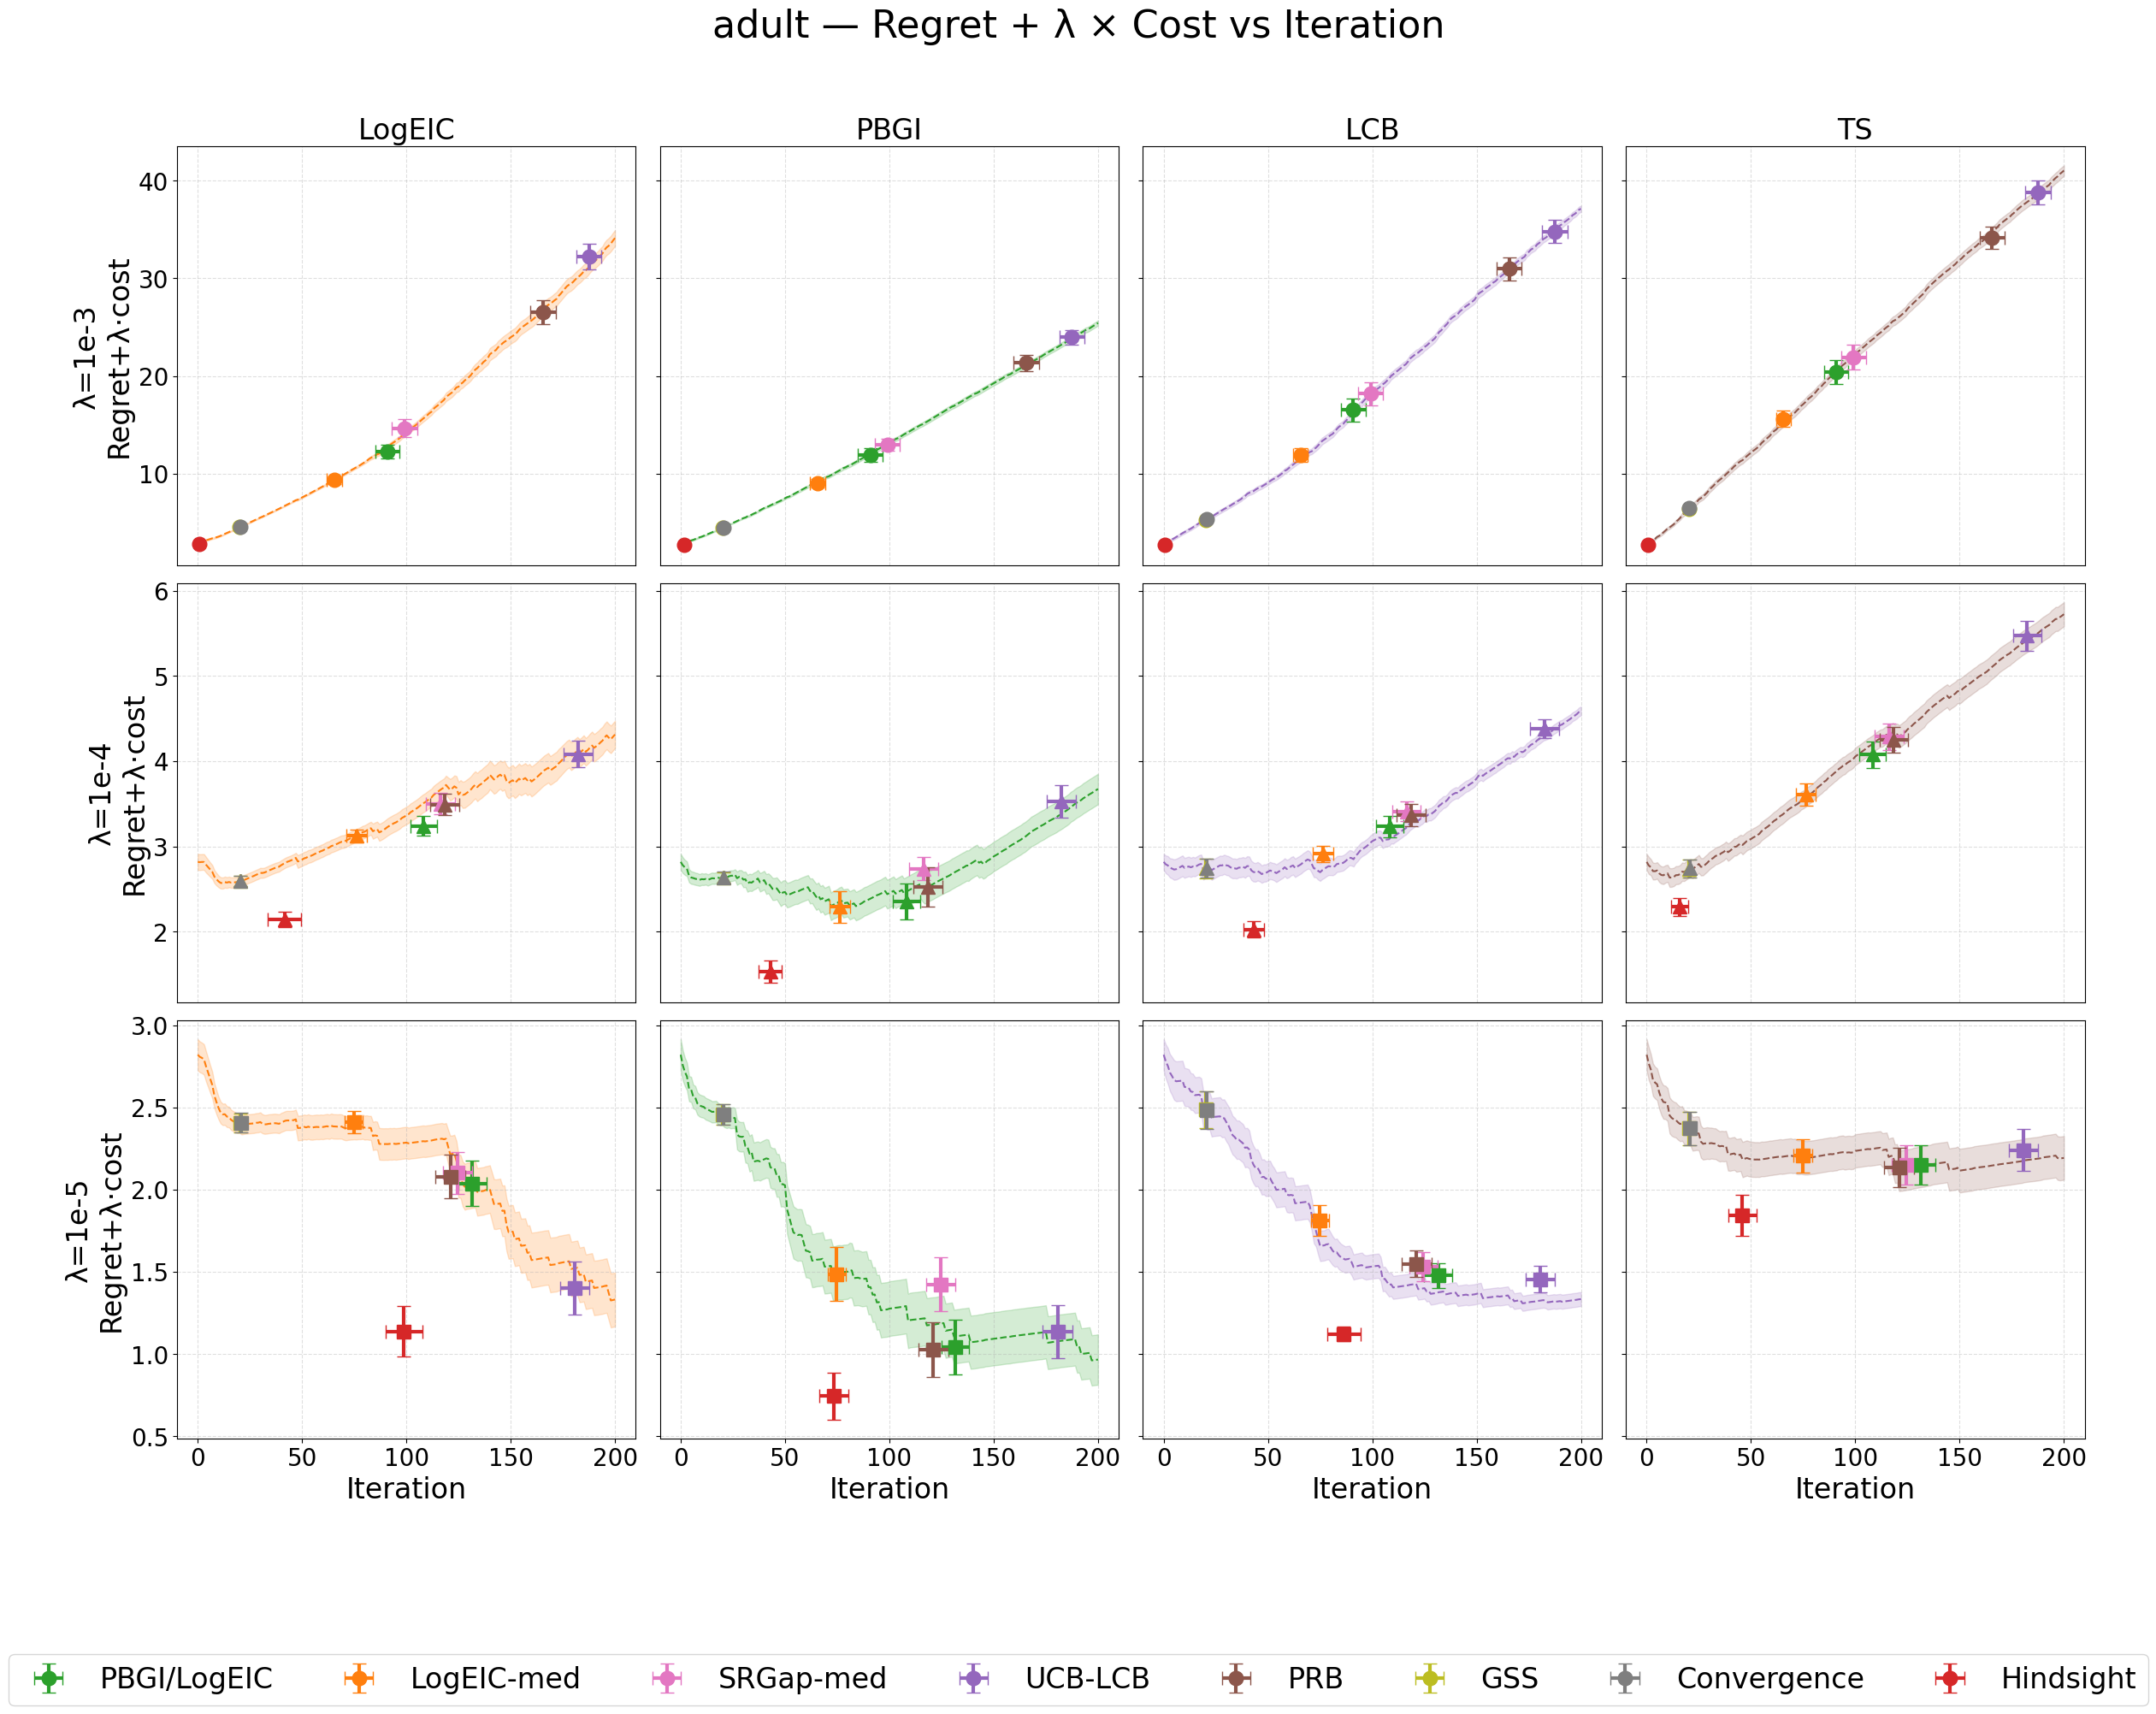

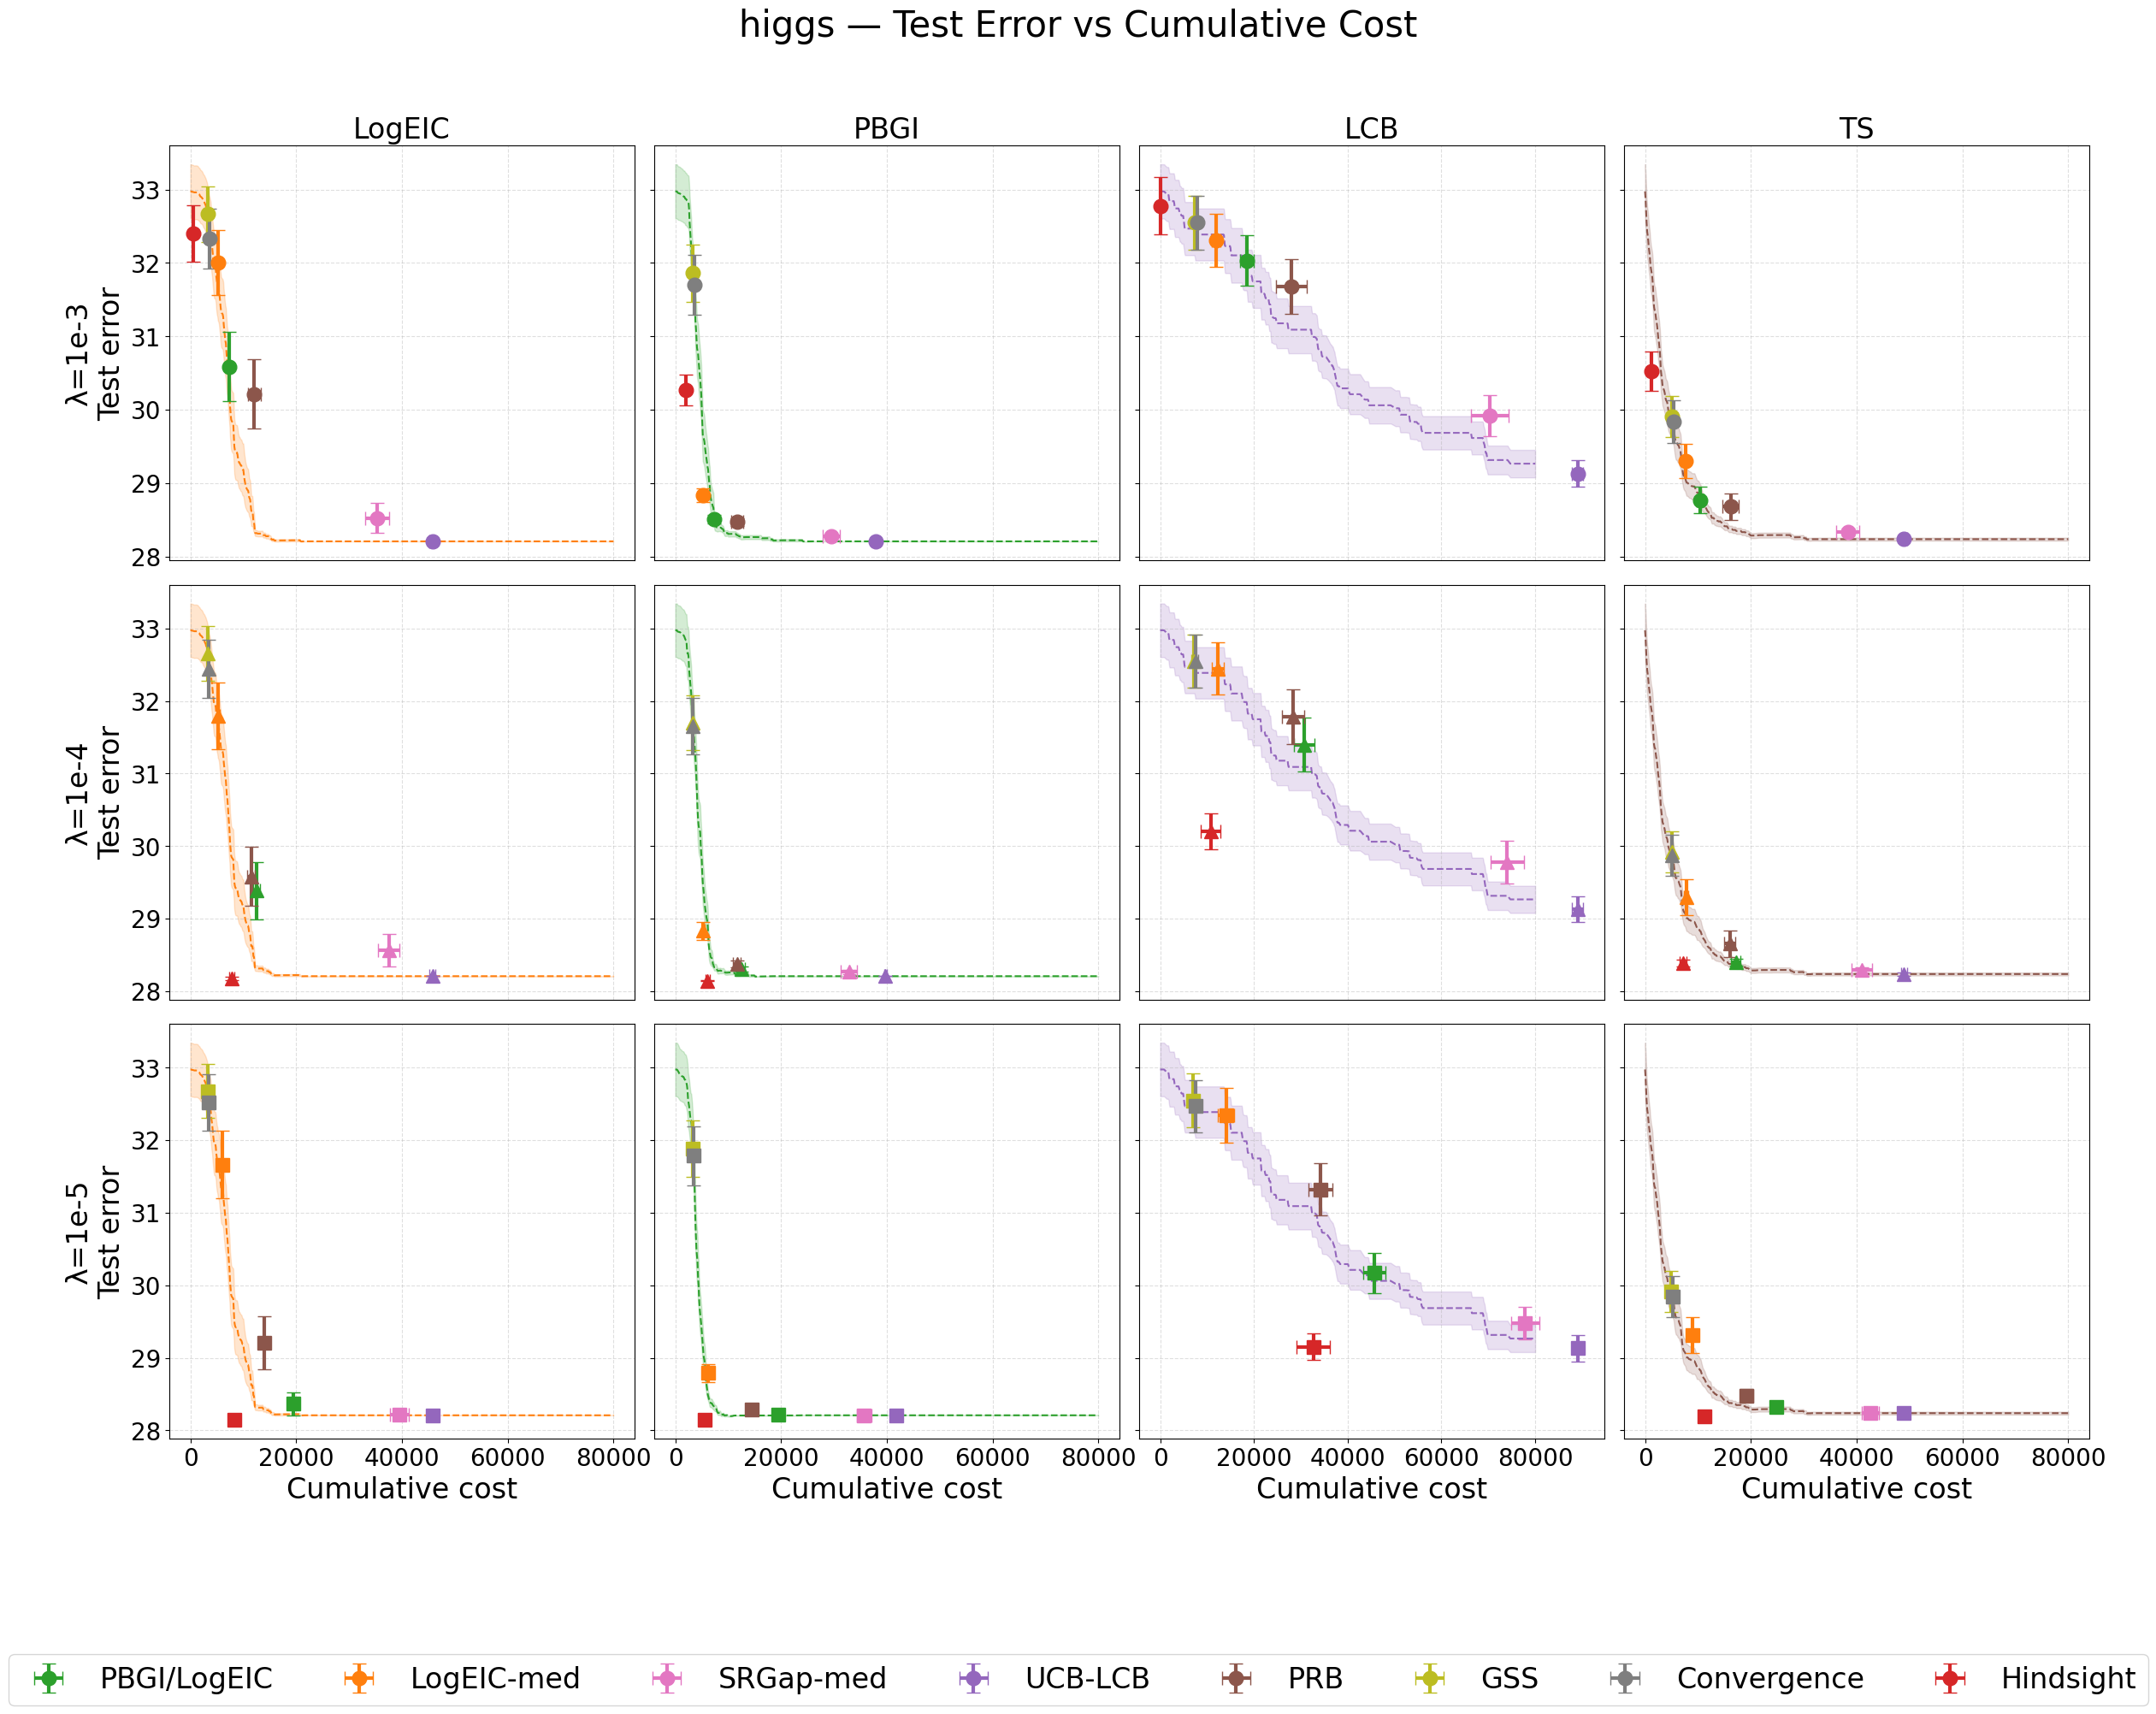

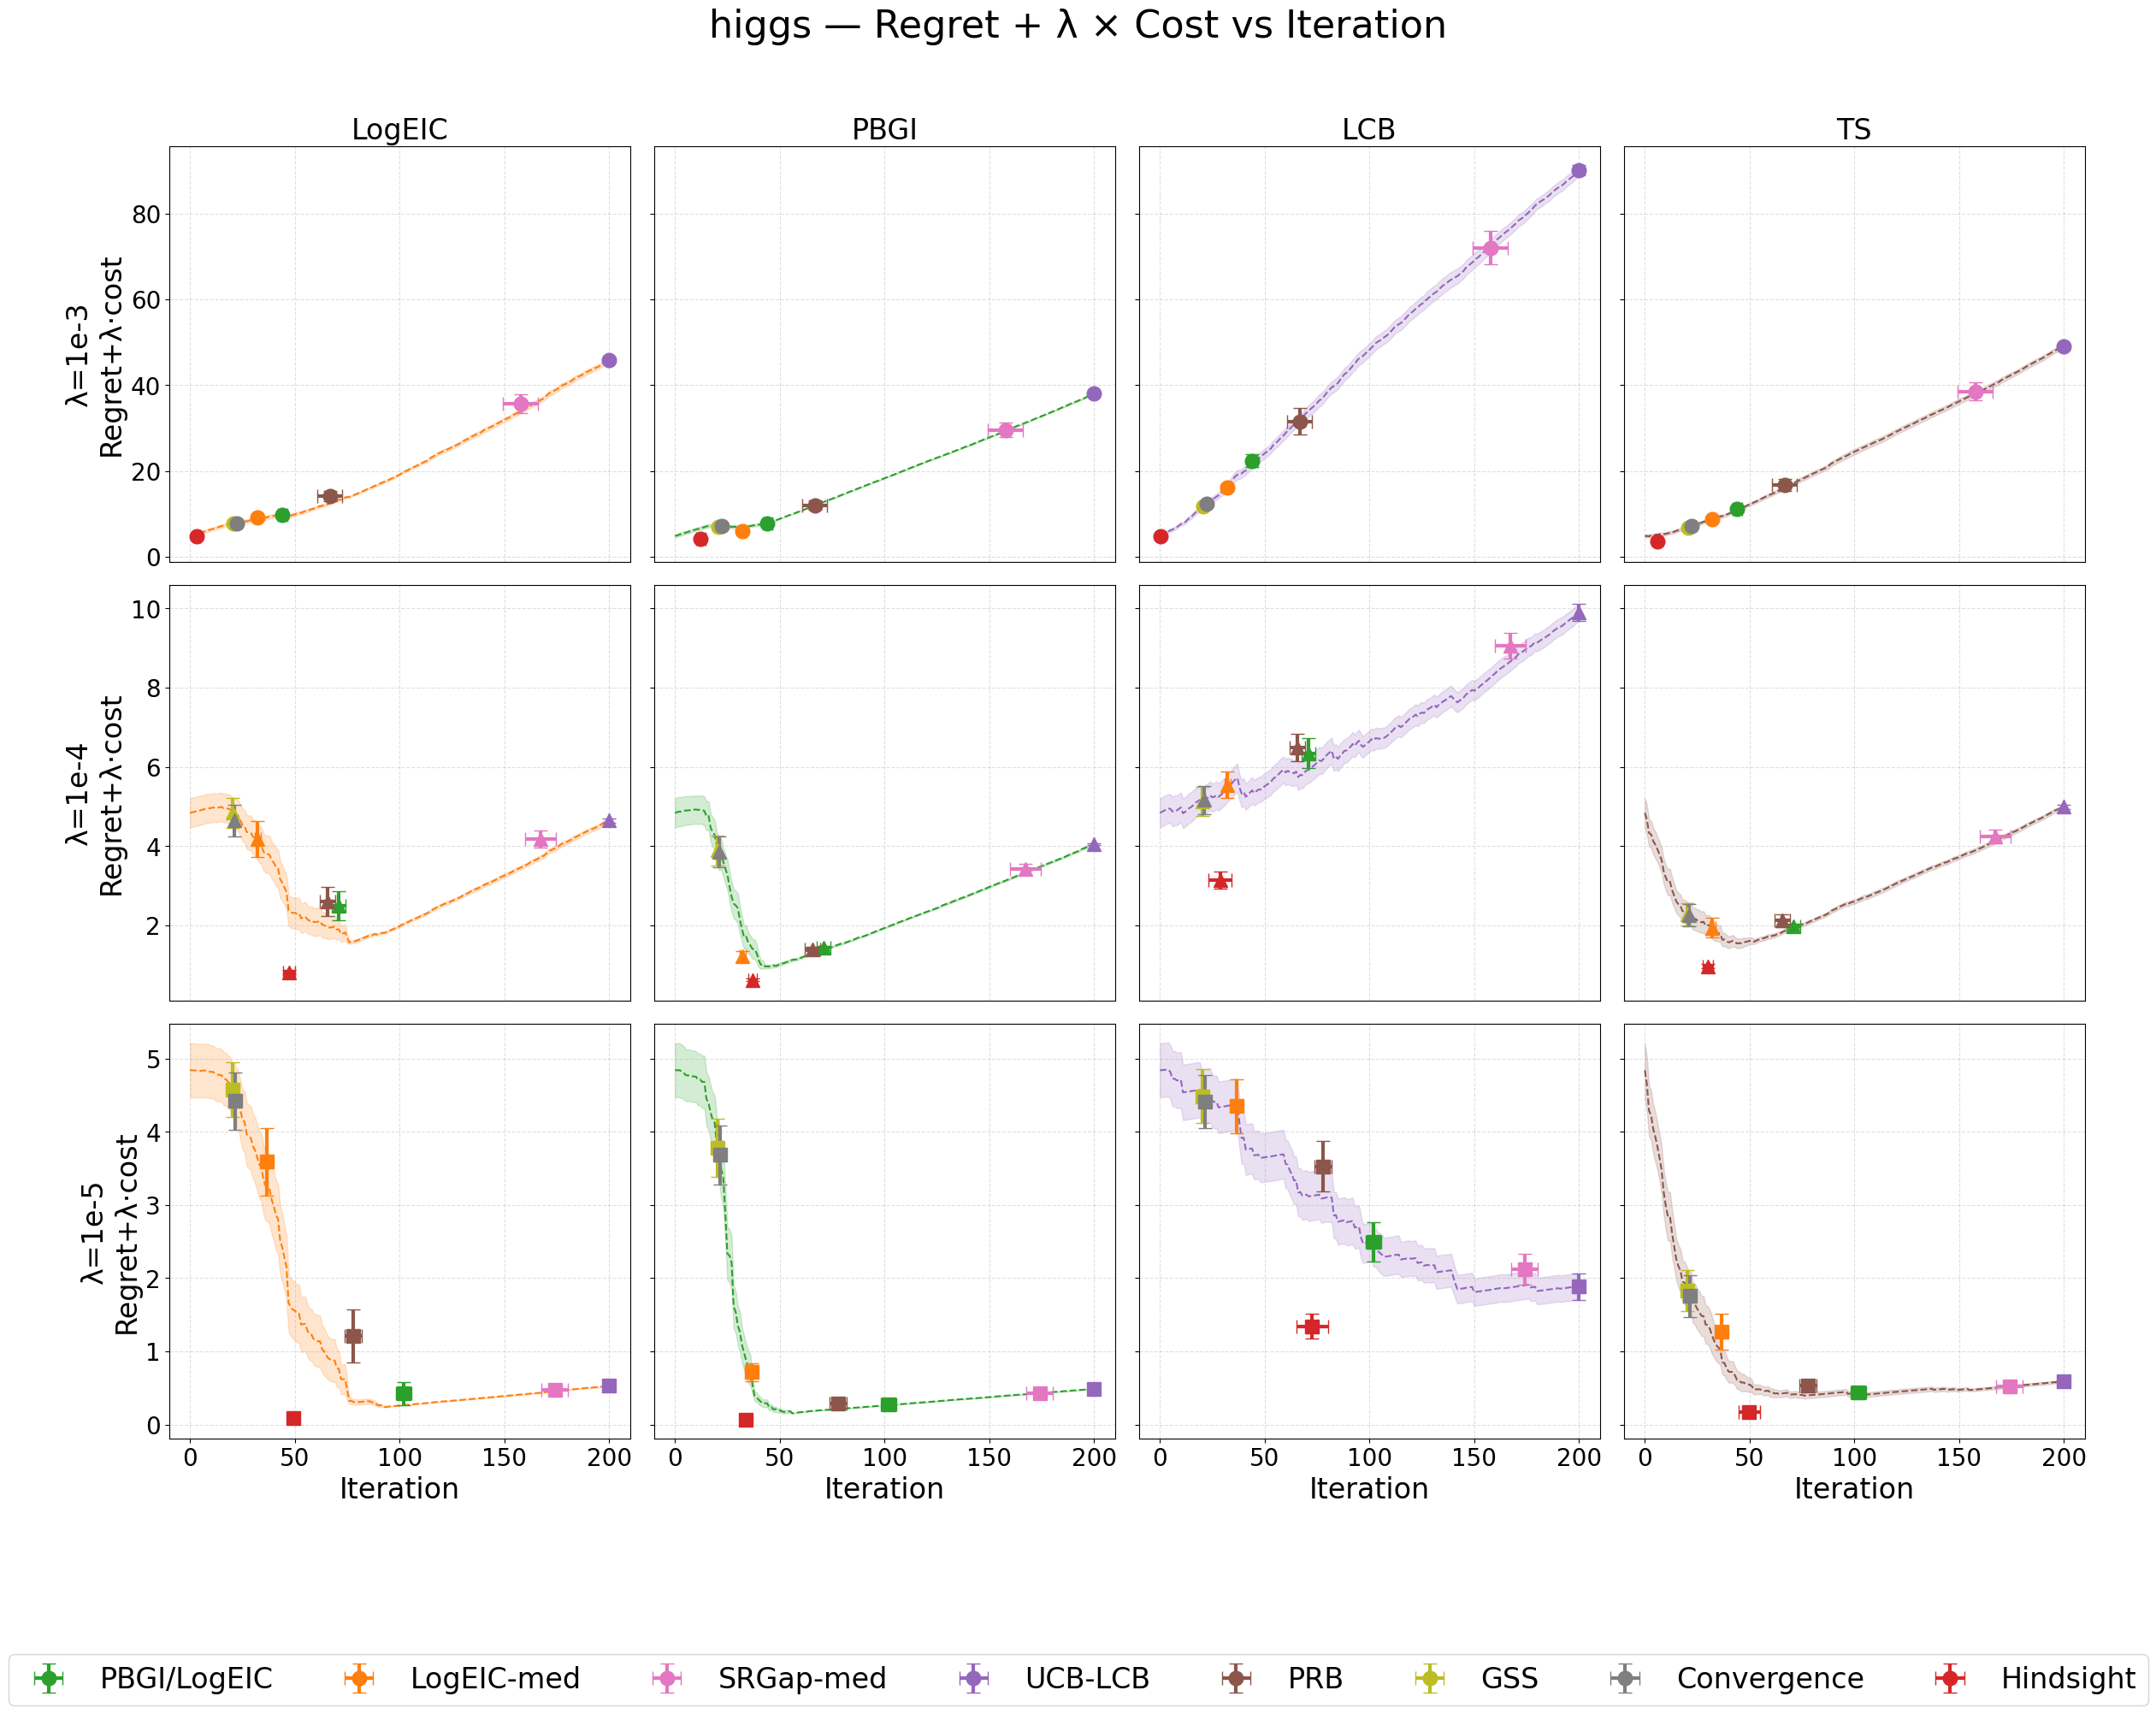

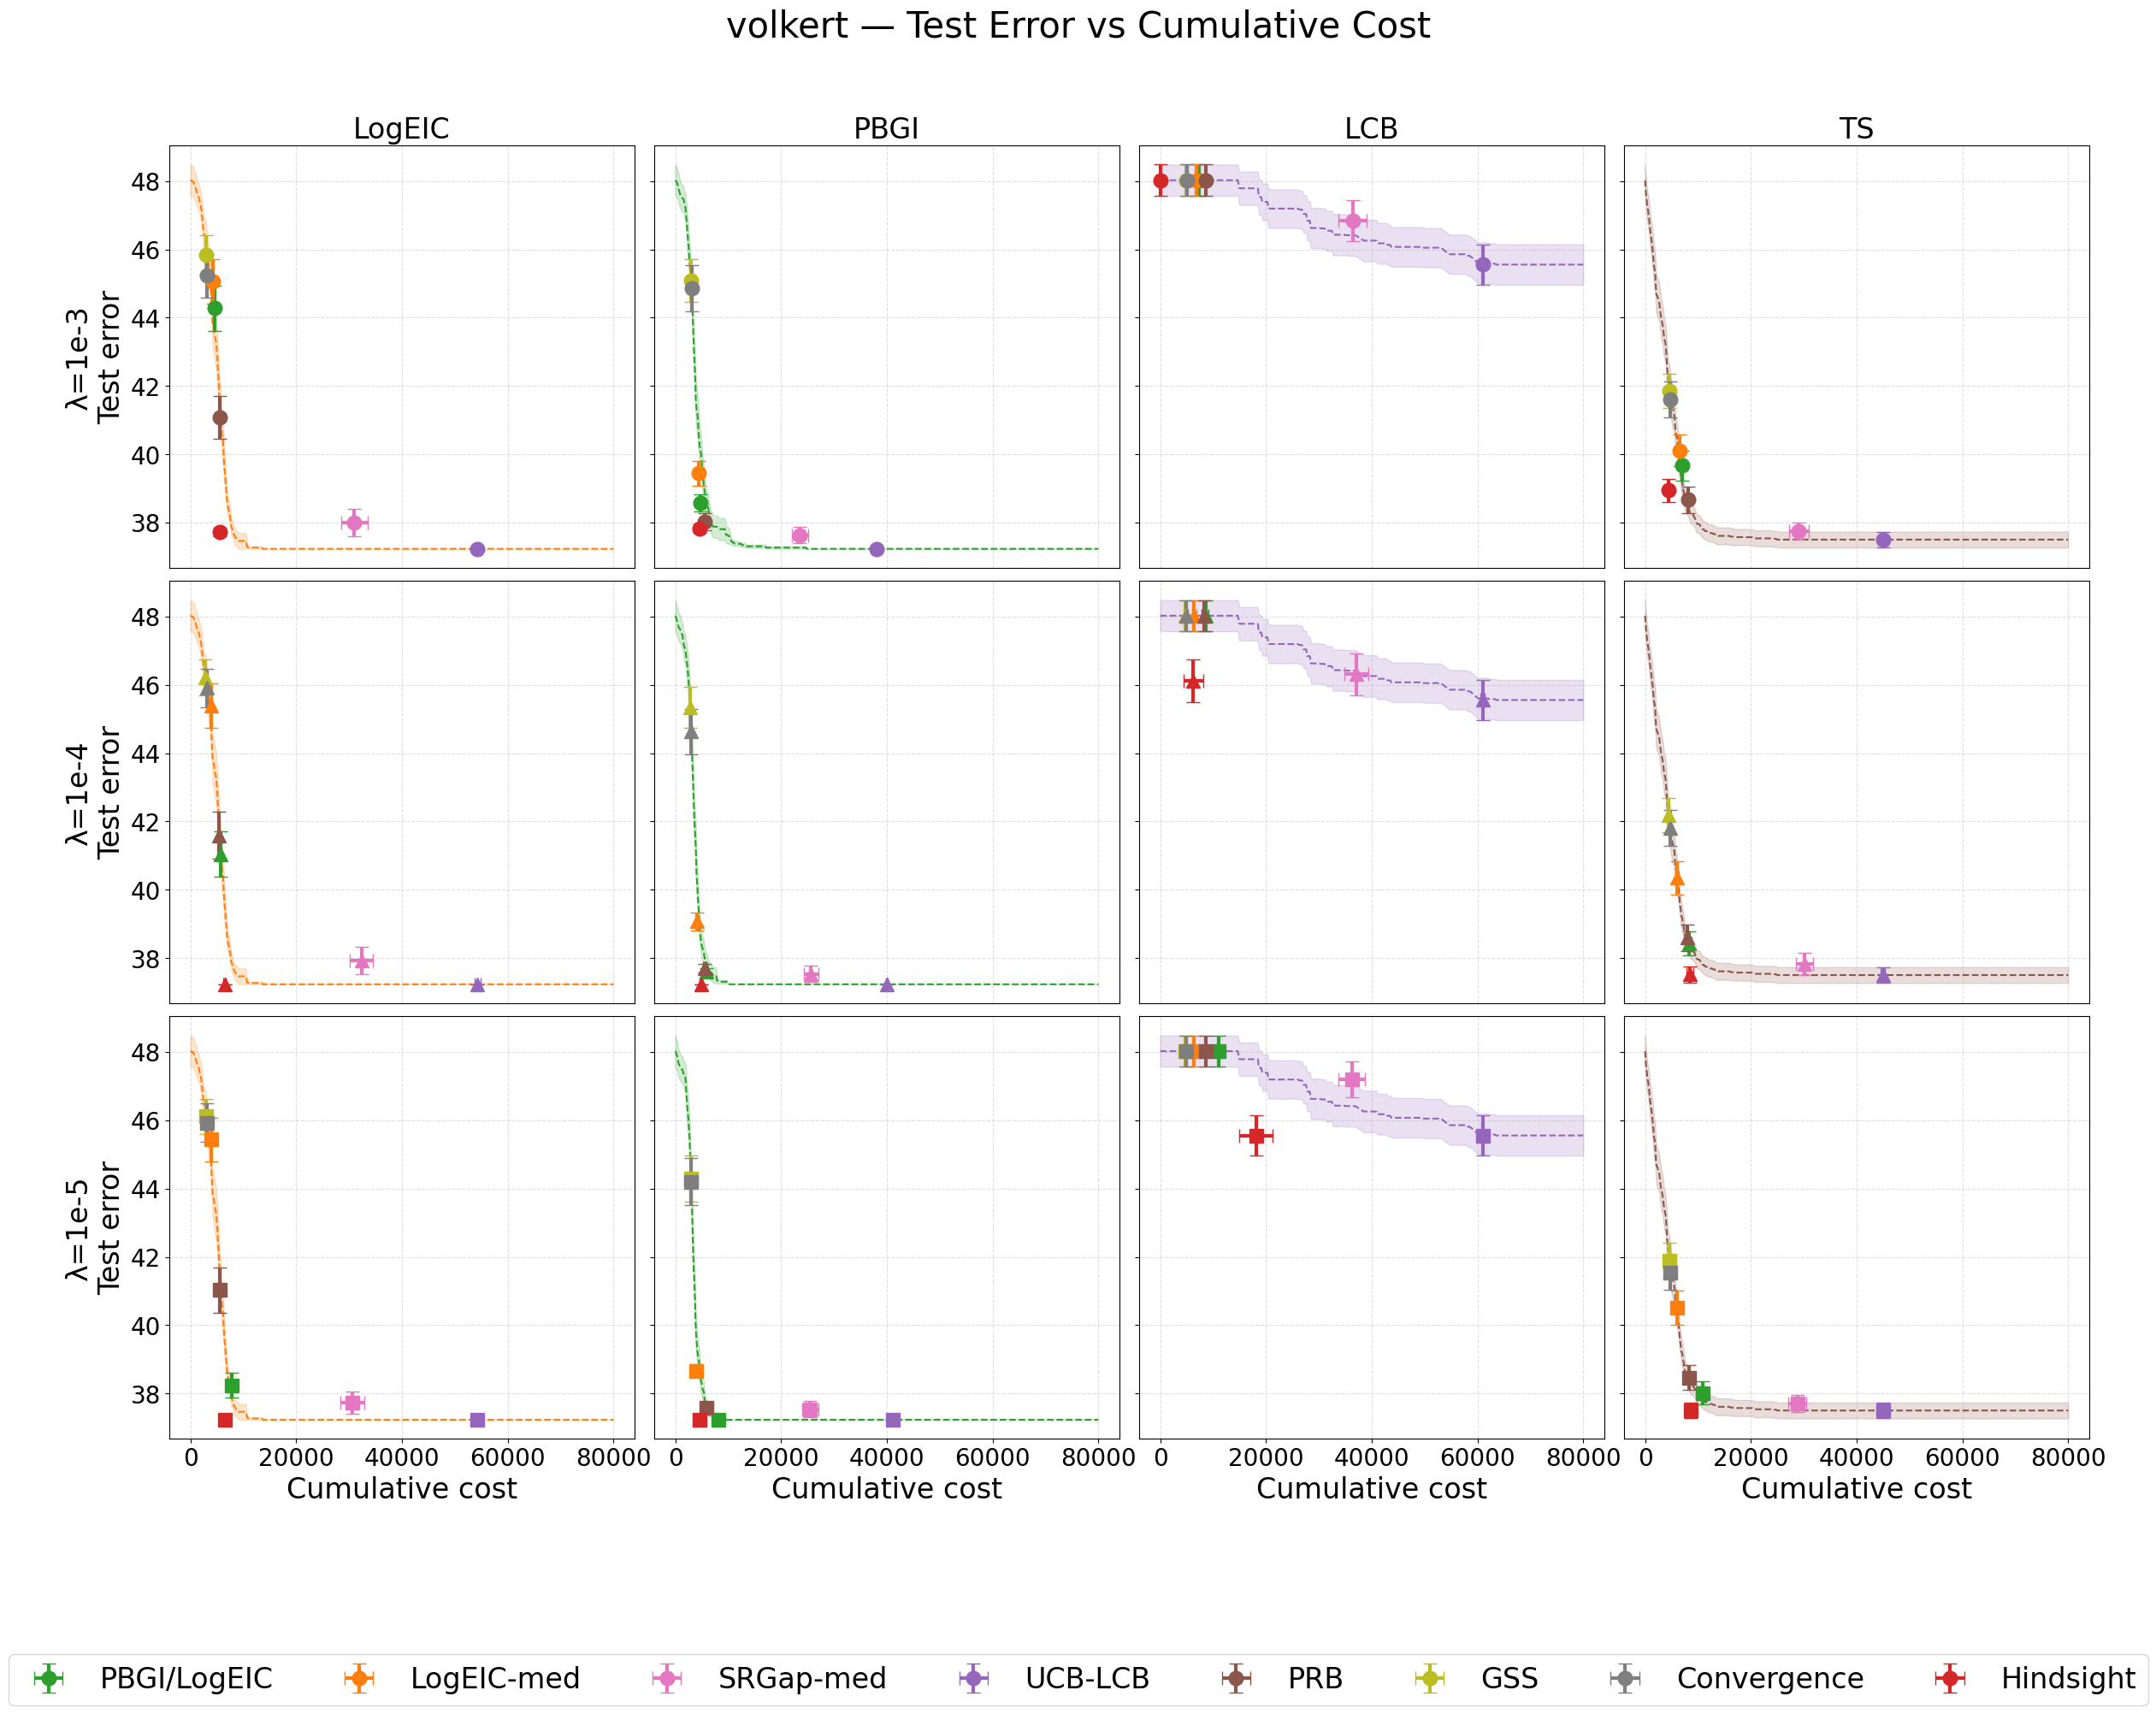

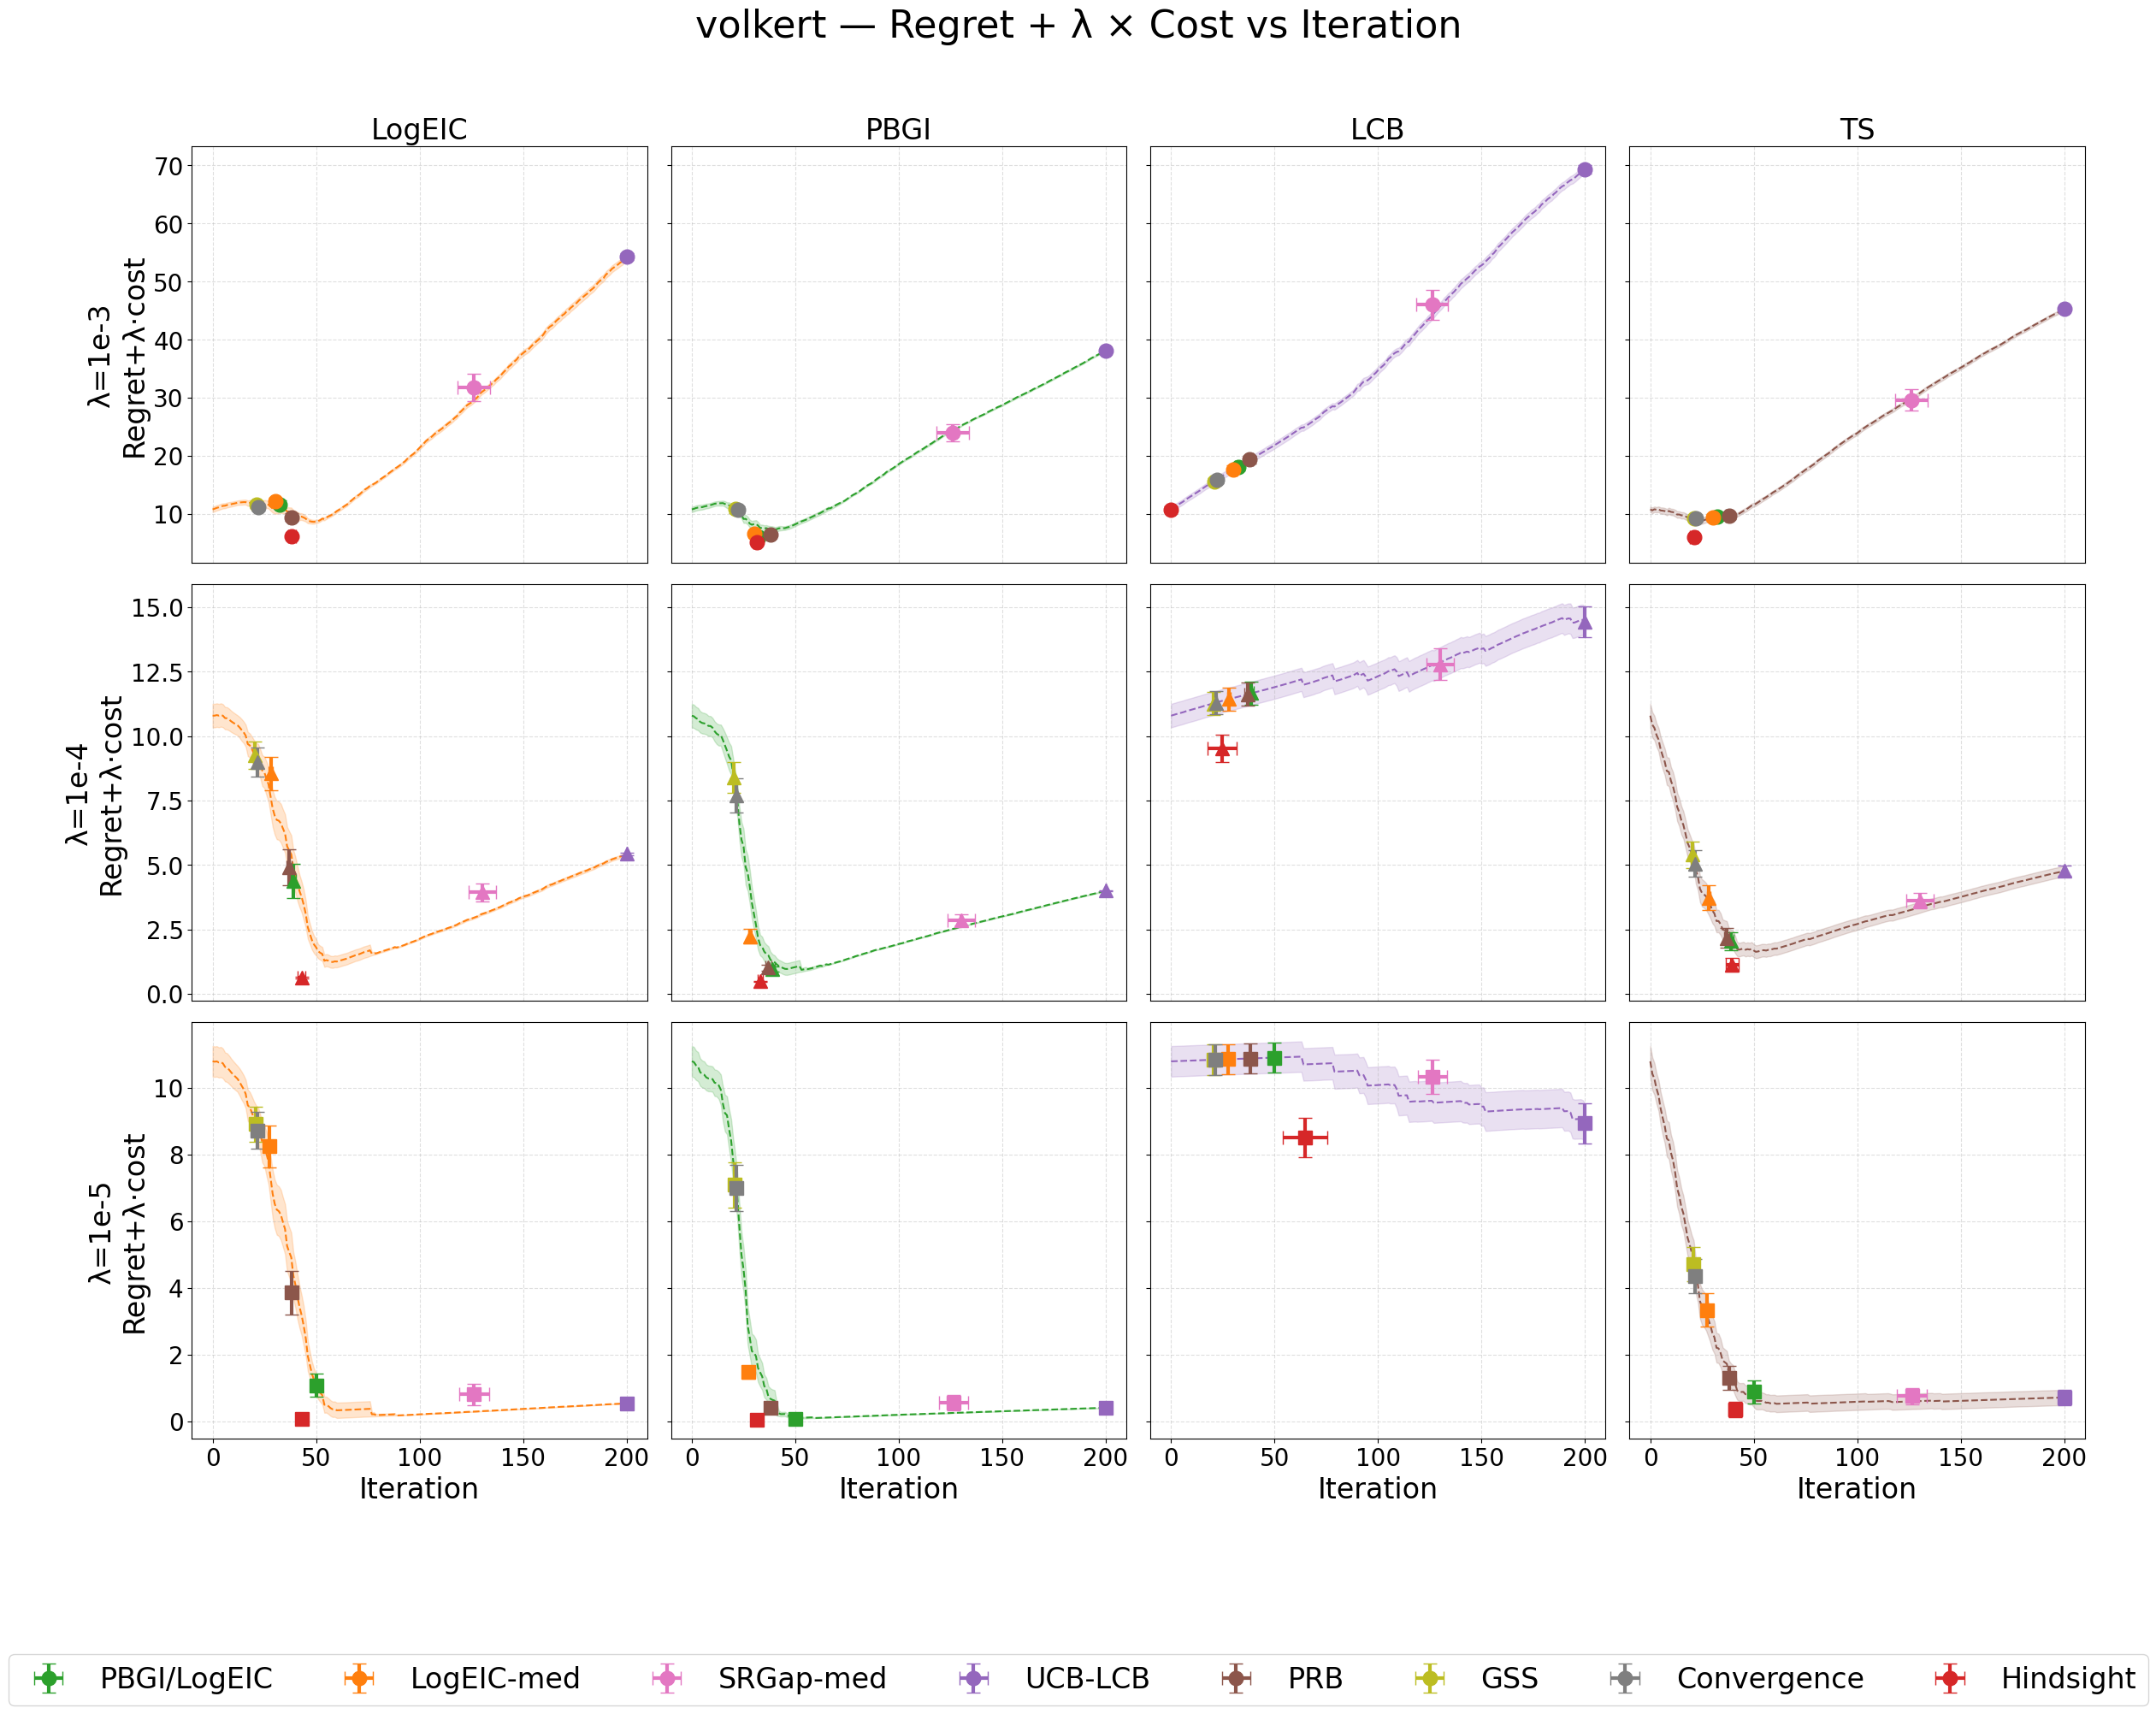

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# === User‐provided data and helper functions (assumed to exist) ===
# metrics_per_acq[d][acq_key]["cumulative cost"]
# test_metrics_per_acq[d][acq_key]["final test error"]
# bench.query_best_final(dataset, "final_test_accuracy", "final_test_accuracy", 0)

# === Config ===
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
lambdas       = [1e-3, 1e-4, 1e-5]
acq_order     = ['LogEIC', 'PBGI', 'LCB', 'TS']
init          = 20

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult":         40000,
    "higgs":         40000,
    "volkert":       40000
}
cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult":         40000,
    "higgs":         80000,
    "volkert":       80000
}

# === Color and marker settings ===
color_dict = {
    'LogEIC':      'tab:orange',
    'LogEIC-med':  'tab:orange',
    'PBGI(1e-3)':  'tab:green',
    'PBGI(1e-4)':  'tab:green',
    'PBGI(1e-5)':  'tab:green',
    'LCB':         'tab:purple',
    'UCB-LCB':     'tab:purple',
    'SRGap-med':   'tab:pink',
    'TS':          'tab:brown',
    'PRB':         'tab:brown',
    'GSS':         'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight':   'tab:red'
}
marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's'
}

# === Build stopping_rules for each λ ===
stopping_rules = []
for lam in lambdas:
    lam_str   = f"1e-{int(round(-np.log10(lam)))}"  # “1e-3”, “1e-4”, “1e-5”
    fixed_acq = f"PBGI({lam_str})"
    marker    = marker_dict[lam_str]

    templates = [
        {
            'stp_key':      'PBGI',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa][f"{fa} acq"][seed][i] >=
                metrics_per_acq[d][fa]["current best observed"][seed][i - 1]
            ))
        },
        # {
        #     'stp_key':      'LogEIC',
        #     'is_hindsight': False,
        #     'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
        #         i >= init and
        #         metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= np.log(lam)
        #     ))
        # },
        {
            'stp_key':      'LogEIC-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= (
                    np.log(0.01) +
                    np.nanmedian(metrics_per_acq[d][fa]["LogEIC acq"][seed][1:21])
                )
            ))
        },
        {
            'stp_key':      'SRGap-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["exp min regret gap"][seed][i] <=
                0.1 * np.nanmedian(
                    metrics_per_acq[d][fa]["exp min regret gap"][seed][1:21]
                )
            ))
        },
        {
            'stp_key':      'UCB-LCB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["regret upper bound"][seed][i] <= 0.01
            ))
        },
        {
            'stp_key':      'PRB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["PRB"][seed][i] >= 0.95
            ))
        },
        {
            'stp_key':      'GSS',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and (
                    (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                     np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     )) == 0
                ) or (
                    ((metrics_per_acq[d][fa]["current best observed"][seed][i - 5] -
                      metrics_per_acq[d][fa]["current best observed"][seed][i]) /
                     (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                      np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     ))
                    ) <= 0.01
                )
            ))
        },
        {
            'stp_key':      'Convergence',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["current best observed"][seed][i] ==
                metrics_per_acq[d][fa]["current best observed"][seed][i - 5]
            ))
        },
        {
            'stp_key':      'Hindsight',
            'is_hindsight': True,
            'condition_fn': None
        }
    ]

    for temp in templates:
        rule = {
            'acq_key':      fixed_acq,
            'stp_key':      temp['stp_key'],
            'is_hindsight': temp['is_hindsight'],
            'marker':       marker,
            'color':        color_dict.get(temp['stp_key'], color_dict[fixed_acq]),
            'label':        'PBGI/LogEIC' if temp['stp_key'] == 'PBGI' else temp['stp_key']
        }
        if temp['condition_fn'] is not None:
            rule['condition_fn'] = temp['condition_fn']
        stopping_rules.append(rule)

# === Plotting ===
for d in dataset_names:
    best_acc   = bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)
    best_error = 100. - best_acc

    # === 1) Test error vs cumulative cost ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey="row")
    fig.suptitle(f"{d} — Test Error vs Cumulative Cost", fontsize=30)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            # === Mean test error curve ===
            cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
            curves = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["cumulative cost"])):
                c = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed])
                e = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                idx = np.argsort(c)
                curves.append(np.interp(cost_grid, c[idx], e[idx]))
            curves = np.vstack(curves)
            mean_c = curves.mean(axis=0)
            sem_c  = curves.std(axis=0) / np.sqrt(curves.shape[0])

            ax.plot(cost_grid, mean_c, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(cost_grid, mean_c - sem_c, mean_c + sem_c, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_costs = []
                for seed in range(curves.shape[0]):
                    errs = test_metrics_per_acq[d][fixed_acq]["final test error"][seed]
                    costs = metrics_per_acq[d][fixed_acq]["cumulative cost"][seed]
                    if rule['is_hindsight']:
                        regs = np.array(errs) - best_error + lam * np.array(costs)
                        idx = np.argmin(regs)
                    else:
                        idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                    stop_vals.append(errs[idx])
                    stop_costs.append(costs[idx])

                mx = np.mean(stop_costs)
                my = np.mean(stop_vals)
                sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)  # only first row

            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nTest error", fontsize=24)
            if i == 2:
                ax.set_xlabel("Cumulative cost", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

    # === 2) Regret + λ·cost vs iteration ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey='row')
    fig.suptitle(f"{d} — Regret + λ × Cost vs Iteration", fontsize=32)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            regs_all = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["cumulative cost"])):
                errs = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                costs = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed])
                regs_all.append((errs - best_error) + lam * costs)
            regs_all = np.vstack(regs_all)
            mean_r = regs_all.mean(axis=0)
            sem_r  = regs_all.std(axis=0) / np.sqrt(regs_all.shape[0])
            iters  = np.arange(mean_r.shape[0])

            ax.plot(iters, mean_r, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(iters, mean_r - sem_r, mean_r + sem_r, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_iters = []
                for seed in range(regs_all.shape[0]):
                    seq = regs_all[seed]
                    if rule['is_hindsight']:
                        idx = np.argmin(seq)
                    else:
                        idx = next((k for k in range(init, len(seq)) if rule['condition_fn'](k, seed, d)), len(seq) - 1)
                    stop_vals.append(seq[idx])
                    stop_iters.append(idx)

                mx = np.mean(stop_iters)
                my = np.mean(stop_vals)
                sx = np.std(stop_iters) / np.sqrt(len(stop_iters))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)
            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nRegret+λ·cost", fontsize=24)
            if i == 2:
                ax.set_xlabel("Iteration", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

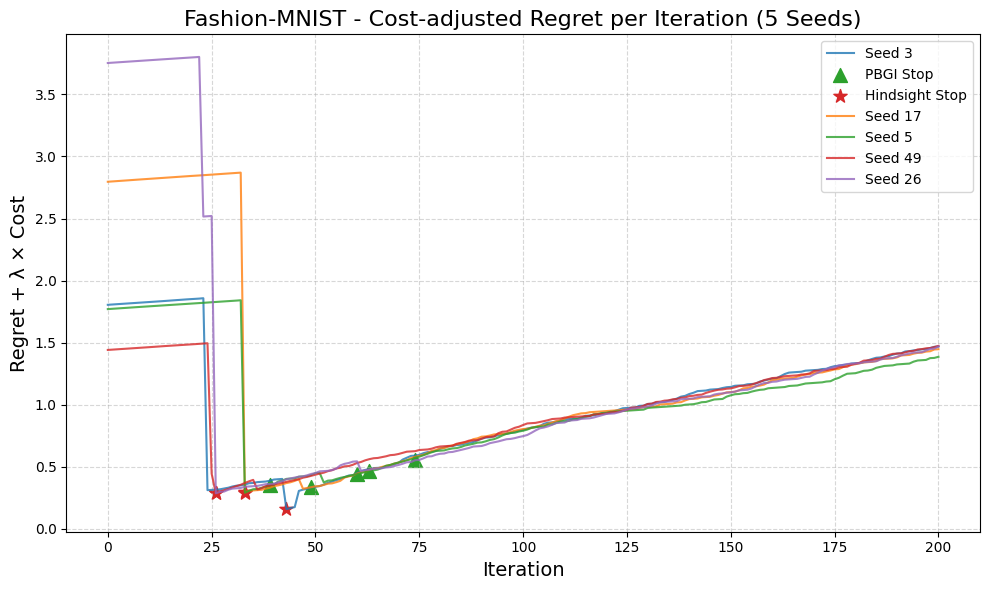

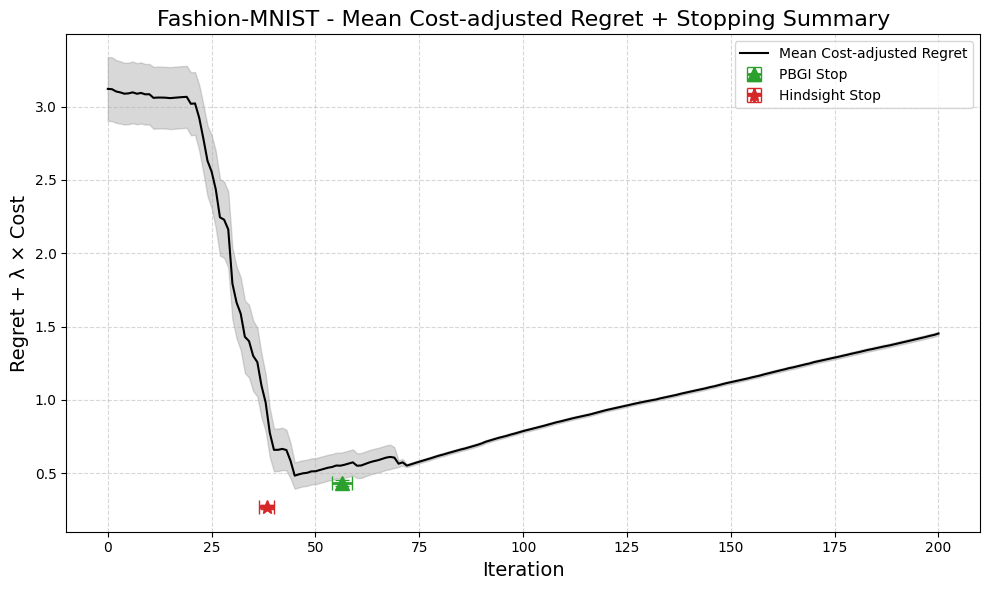

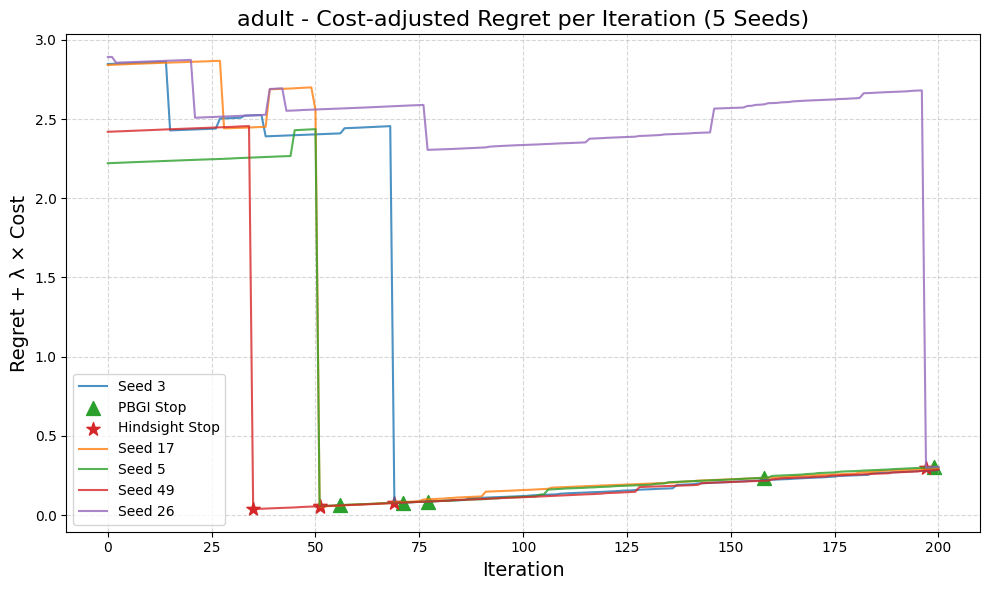

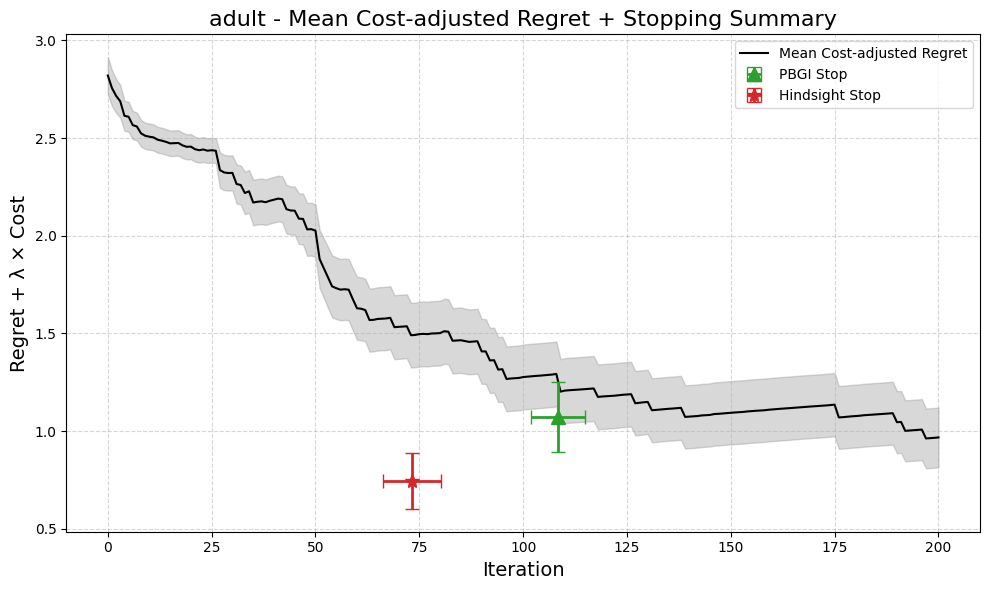

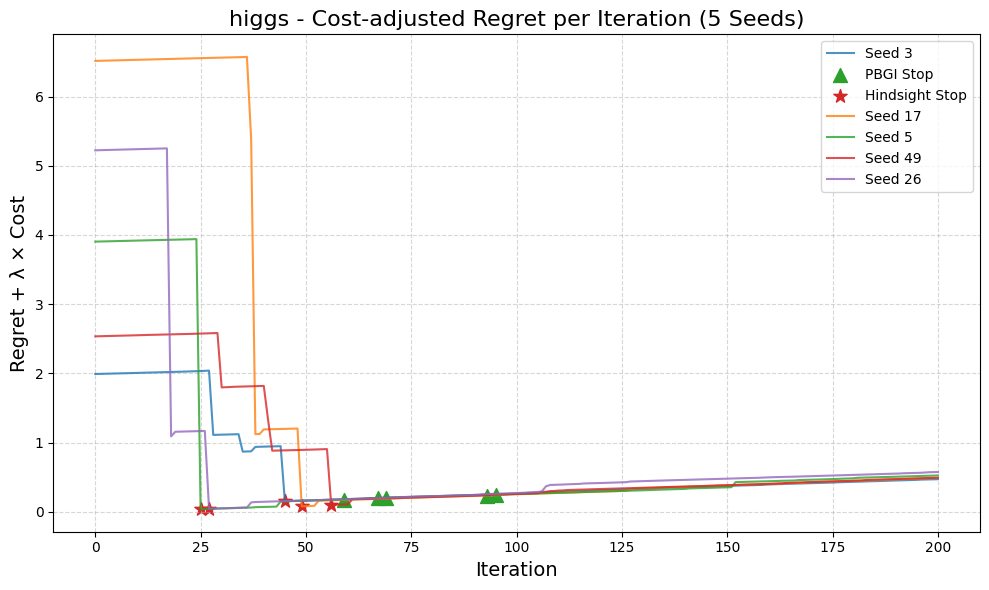

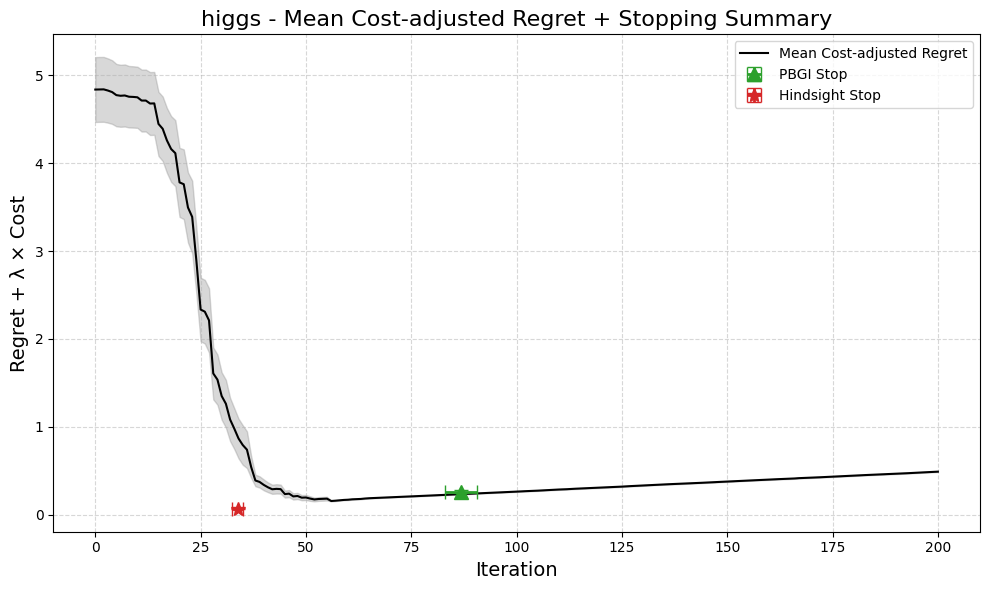

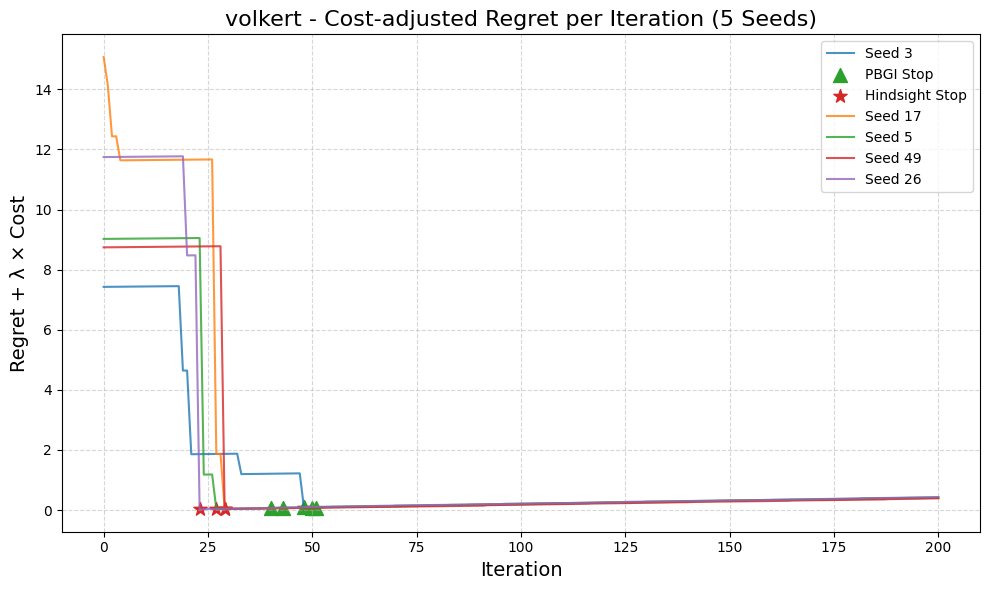

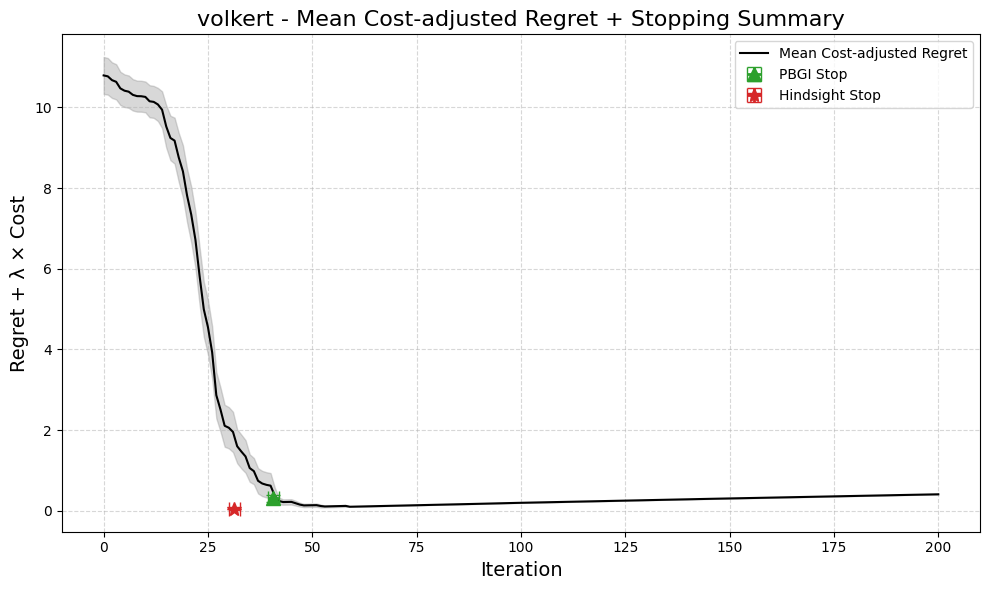

In [18]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(123)
all_seed_ids = range(50)
sampled_seed_ids = random.sample(all_seed_ids, 5)

for d in dataset_names:
    cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
    best_test_error = 100-bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)

    # === 1. Plot 5 individual seeds with stopping points ===
    plt.figure(figsize=(10, 6))

    for seed_id in sampled_seed_ids:
        test_error_arr = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed_id])
        cost_arr = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed_id])
        regret_arr = test_error_arr - best_test_error
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        plt.plot(range(len(adjusted_regret_arr)), adjusted_regret_arr, label=f"Seed {seed_id}", alpha=0.8)

        # Stopping point: PBGI
        try:
            stop_id_pbgi = next(i for i in range(1, len(test_error_arr)) if
                                metrics_per_acq[d][fixed_acq]["PBGI(1e-4) acq"][seed_id][i] >=
                                metrics_per_acq[d][fixed_acq]["current best observed"][seed_id][i - 1])
        except StopIteration:
            stop_id_pbgi = None

        if stop_id_pbgi is not None:
            stop_val_pbgi = adjusted_regret_arr[stop_id_pbgi]
            plt.scatter(stop_id_pbgi, stop_val_pbgi, color='tab:green', marker='^', s=100,
                        label=f"PBGI Stop" if seed_id == sampled_seed_ids[0] else None)

        # Hindsight stopping
        stop_id_hindsight = np.argmin(adjusted_regret_arr)
        stop_val_hindsight = adjusted_regret_arr[stop_id_hindsight]
        plt.scatter(stop_id_hindsight, stop_val_hindsight, color='tab:red', marker='*', s=100,
                    label=f"Hindsight Stop" if seed_id == sampled_seed_ids[0] else None)

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Cost-adjusted Regret per Iteration (5 Seeds)", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === 2. Plot mean curve and mean stopping points ===
    plt.figure(figsize=(10, 6))
    max_len = max(len(test_metrics_per_acq[d][fixed_acq]["final test error"][seed_id])
                  for seed_id in all_seed_ids)

    interpolated_adjusted_regrets = []

    for seed_id in all_seed_ids:
        test_error_arr = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed_id])
        cost_arr = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed_id])
        adjusted_regret_arr = test_error_arr - best_test_error + lmbda * cost_arr

        padded = np.full(max_len, np.nan)
        padded[:len(adjusted_regret_arr)] = adjusted_regret_arr
        interpolated_adjusted_regrets.append(padded)

    interpolated_adjusted_regrets = np.array(interpolated_adjusted_regrets)
    mean_adjusted_regret = np.nanmean(interpolated_adjusted_regrets, axis=0)
    sem_adjusted_regret = np.nanstd(interpolated_adjusted_regrets, axis=0) / np.sqrt(
        np.sum(~np.isnan(interpolated_adjusted_regrets), axis=0))

    plt.plot(range(max_len), mean_adjusted_regret, color="black", label="Mean Cost-adjusted Regret")
    plt.fill_between(range(max_len), mean_adjusted_regret - sem_adjusted_regret,
                     mean_adjusted_regret + sem_adjusted_regret, color="gray", alpha=0.3)

    # Collect stop points
    stopping_info = {'PBGI': {'stop_iters': [], 'stop_vals': []},
                     'Hindsight': {'stop_iters': [], 'stop_vals': []}}

    for seed_id in all_seed_ids:
        test_error_arr = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed_id])
        cost_arr = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed_id])
        adjusted_regret_arr = test_error_arr - best_test_error + lmbda * cost_arr

        try:
            stop_id_pbgi = next(i for i in range(1, len(test_error_arr)) if
                                metrics_per_acq[d][fixed_acq]["PBGI(1e-4) acq"][seed_id][i] >=
                                metrics_per_acq[d][fixed_acq]["current best observed"][seed_id][i - 1])
            stopping_info['PBGI']['stop_iters'].append(stop_id_pbgi)
            stopping_info['PBGI']['stop_vals'].append(adjusted_regret_arr[stop_id_pbgi])
        except StopIteration:
            pass

        stop_id_hindsight = np.argmin(adjusted_regret_arr)
        stopping_info['Hindsight']['stop_iters'].append(stop_id_hindsight)
        stopping_info['Hindsight']['stop_vals'].append(adjusted_regret_arr[stop_id_hindsight])

    # Plot means + error bars
    for rule_name, info in stopping_info.items():
        if info['stop_iters']:
            iters = np.array(info['stop_iters'])
            vals = np.array(info['stop_vals'])

            mean_iter = np.mean(iters)
            sem_iter = np.std(iters) / np.sqrt(len(iters))

            mean_val = np.mean(vals)
            sem_val = np.std(vals) / np.sqrt(len(vals))

            marker = '^' if rule_name == 'PBGI' else '*'
            color = 'tab:green' if rule_name == 'PBGI' else 'tab:red'

            plt.errorbar(mean_iter, mean_val, xerr=sem_iter, yerr=sem_val,
                         fmt=marker, color=color, markersize=10, capsize=5,
                         linewidth=2, label=f"{rule_name} Stop")

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Mean Cost-adjusted Regret + Stopping Summary", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

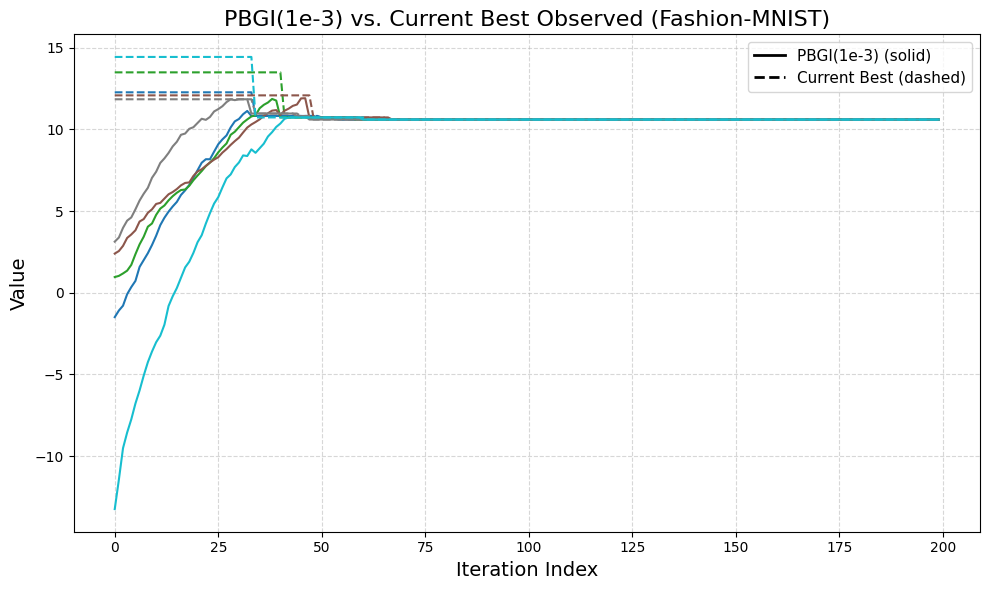

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Use same fixed acquisition and dataset
acq_key = "PBGI(1e-3)"
d = "Fashion-MNIST"

colors = plt.cm.tab10(np.linspace(0, 1, len(sampled_seed_ids)))
plt.figure(figsize=(10, 6))

for seed_id, color in zip(sampled_seed_ids, colors):
    arr1 = metrics_per_acq[d][acq_key]["PBGI(1e-3) acq"][seed_id][1:]
    arr2 = metrics_per_acq[d][acq_key]["current best observed"][seed_id][:-1]

    iterations = np.arange(len(arr1))

    plt.plot(iterations, arr1, color=color, label=f'{acq_key} seed {seed_id}' if seed_id == sampled_seed_ids[0] else "")
    plt.plot(iterations, arr2, color=color, linestyle='--', 
             label=f'Current Best seed {seed_id}' if seed_id == sampled_seed_ids[0] else "")

plt.xlabel("Iteration Index", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title(f"{acq_key} vs. Current Best Observed ({d})", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [
    Line2D([0], [0], color='black', lw=2, label=f'{acq_key} (solid)'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Current Best (dashed)')
]
plt.legend(handles=custom_lines, fontsize=11, loc="best")

plt.tight_layout()
plt.show()